# Observation: 2D

## Quickly inspect data

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

ds = xr.open_dataset('../data/sst.mnmean.nc')  # ERSSTv5 typically has lon 0..360
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 132MB
Dimensions:    (lat: 89, lon: 180, time: 2059, nbnds: 2)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB ...
    sst        (time, lat, lon) float32 132MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ..

In [4]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sst.hvplot('lon', 'lat', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_2984893/1422216783.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [lon,lat]   (Monthly Means of Sea Surface Temperature)

## PCA

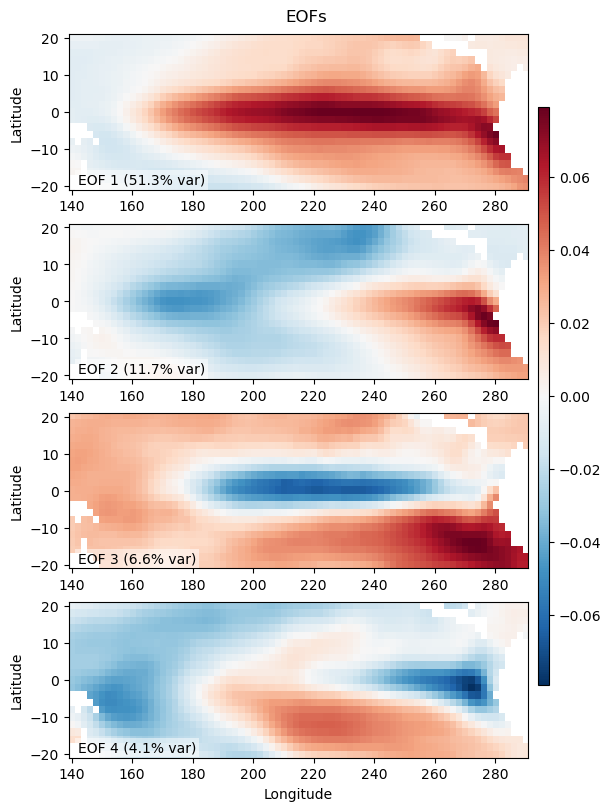

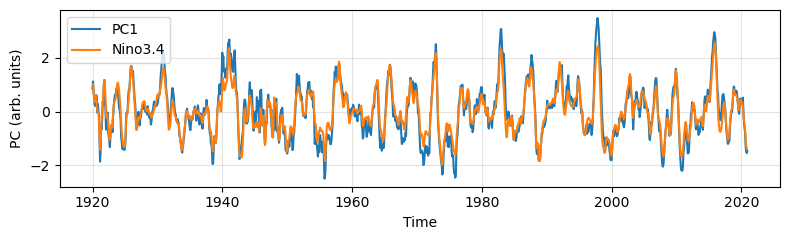

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=False,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.cos(lat_rad)
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = (anoms*w2d).sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
        
    # anoms_w = anoms * np.sqrt(w2d)
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=np.sqrt(w2d))
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    #ds = xr.open_dataset("../ENSO-data/data/sst.mnmean.nc")
    ds = xr.open_dataset("../data/sst.mnmean.nc")
    da = ds["sst"]  # ERSSTv5: 'sst'
    res = pca_ersstv5(
        da,
        time_slice=("1920-01", "2020-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [13]:
ds_out = xr.Dataset(
    data_vars={
        "EOFs":   res["EOFs"],     # (mode, lat, lon)
        "PCs":    res["PCs"],      # (time, mode)
        "EVRs":    res["evrs"],     # (mode)
        "Nino34": res["nino34"],   # (time)
        "anoms":   res["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 EOF/PCA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "EOFs computed with eofs.xarray, weights = sqrt(cos(lat))",
})

out_path = "../data/ersstv5_eof_nino34_1920_2020.nc"
ds_out.to_netcdf(out_path, format="NETCDF4")
print(f"Saved to {out_path}")

Saved to ../data/ersstv5_eof_nino34_1920_2020.nc


In [17]:
res["PCs"].to_numpy().shape

(1212, 4)

## Clustering

### FCM

In [35]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from time import time
import pickle

def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
np.random.seed(0)

########################## load data ############################
file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()
train_size = 1212 # training data size
test_size = 0 # test data size

######################### clustering ############################
K = 5 # number of clusters (regimes)
L = 0 # time delay steps
data = data[:train_size]
Nt, _ = data.shape
features = []
features.append(data)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000, seed=0)
results = cluster_model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

# save the clustering model
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'scaler': scaler,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_ersstv5.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

In [5]:
data_embedded.shape

(1212, 4)

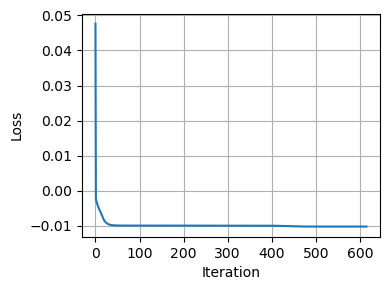

In [36]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

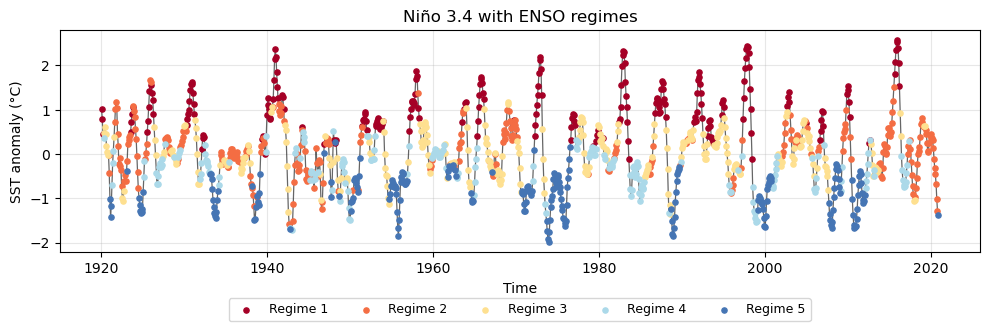

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

def plot_nino34_with_regimes(
    nino34,                   # np.ndarray, shape (Nt,)
    labels,                   # np.ndarray or list, shape (Nt,), ints like 0..K-1 (or -1 for noise)
    time=None,                # None, np.ndarray shape (Nt,), or pandas.DatetimeIndex
    regime_names=None,        # list of names per regime id; len==K
    colors=None,              # list of color strings per regime id; len==K
    rolling=None,             # e.g., 3 or 5 for moving avg window (optional)
    title="Niño 3.4 with clustered regimes"
):
    nino34 = np.asarray(nino34)
    labels = np.asarray(labels)
    assert nino34.shape == labels.shape, "nino34 and labels must have same shape"
    Nt = nino34.size
    if time is None:
        x = np.arange(Nt)
        xlabel = "Time index"
    else:
        x = np.asarray(time)
        xlabel = "Time"
        
    # Handle NaNs: mask both arrays consistently
    good = np.isfinite(nino34) & np.isfinite(labels)
    x_plot = x[good]
    y_plot = nino34[good]
    lab_plot = labels[good].astype(int)

    # Unique regimes (keep order by sorted)
    uniq = np.unique(lab_plot)

    # Build colors
    assert len(colors) >= len(uniq), "Provide enough colors for all regimes"
    palette = colors[:len(uniq)]

    # Map regime id -> color (keep label ids)
    color_map = {lab: palette[i] for i, lab in enumerate(uniq)}

    # Build names
    name_map = {lab: (regime_names[lab] if lab >= 0 else "Noise") for lab in uniq} # If regime ids start at 0..K-1, map directly; for -1 keep "Noise"

    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(x, nino34, 'k', lw=0.9, alpha=0.6)
    for lab in uniq:
        sel = lab_plot == lab
        ax.scatter(x_plot[sel], y_plot[sel], s=14, color=color_map[lab], label=name_map[lab], zorder=3)
    ax.set_ylabel("SST anomaly (°C)")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Deduplicate legend entries (Niño line, rolling mean, regimes)
    handles, labels_ = ax.get_legend_handles_labels()
    seen = {}
    new_h, new_l = [], []
    for h, l in zip(handles, labels_):
        if l not in seen:
            seen[l] = True
            new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, ncol=2, fontsize=9)
    # Legend outside bottom
    ax.legend(
        new_h, new_l,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=len(new_l),
        fontsize=9
    )

    plt.tight_layout()
    return fig, ax

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm.png')
plt.show()


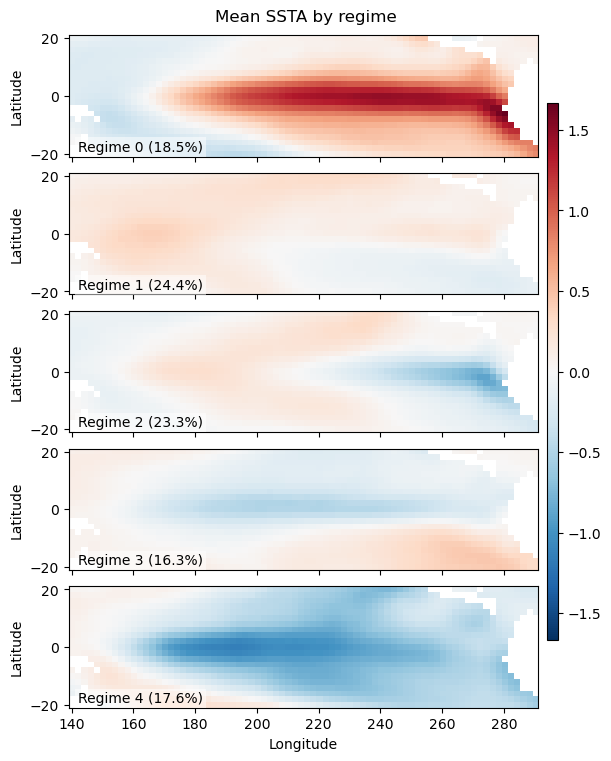

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm.png')
plt.show()

# Models: 2D

## Preprocessing

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    sst               (time, latitude, longitude) float32 79MB ...
    ts_glob           (time) float32 8kB ...
    ts_trop           (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [2]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_2984893/816614438.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

In [3]:
ds.sst

<xarray.DataArray 'sst' (time: 1980, latitude: 50, longitude: 200)> Size: 79MB
[19800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * latitude   (latitude) float64 400B -24.5 -23.5 -22.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 2kB 100.5 101.5 102.5 ... 297.5 298.5 299.5
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [5]:
ds.sst.time

<xarray.DataArray 'time' (time: 2059)> Size: 16kB
array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ..., '2025-05-01T00:00:00.000000000',
       '2025-06-01T00:00:00.000000000', '2025-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-07-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 82361.]

Since model data has different spatial grids from the reanalysis data, coarsening and averaging are needed to align the spatial grids.

In [4]:
# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(139.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

In [5]:
ds_2deg

<xarray.Dataset> Size: 13MB
Dimensions:           (time: 1980, bound: 2, latitude: 21, longitude: 76)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 168B 20.0 18.0 16.0 ... -18.0 -20.0
  * longitude         (longitude) float64 608B 140.0 142.0 144.0 ... 288.0 290.0
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB 1850-01-01 ... 2015-0...
    bounds_latitude   (latitude, bound) float64 336B 19.5 20.5 ... -20.5 -19.5
    bounds_longitude  (longitude, bound) float64 1kB 139.5 140.5 ... 289.5 290.5
    sst               (time, latitude, longitude) float32 13MB 24.46 ... nan
    ts_glob           (time) float32 8kB 13.02 13.06 14.05 ... 15.8 14.86 14.29
    ts_trop           (time) float32 8kB 25.12 25.46 25.91 ... 26.57 26.27 25.98
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribute_branch_time_in_child:   0.0
    original_attribute_branch_time_in_parent:  0.0
    original_attribute_calendar:               proleptic_gregorian
    ...                                        ...
    original_attribute_table_info:             Creation Date:(30 April 2019) ...
    original_attribute_title:                  ACCESS-CM2 output prepared for...
    original_attribute_tracking_id:            hdl:21.14100/246cb7d2-3eb7-412...
    original_attribute_variable_id:            ts
    original_attribute_variant_label:          r1i1p1f1
    original_attribute_version:                v20191108

In [6]:
ds_2deg.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

## Clustering 

First compute 'pseudo-PCs' by projecting the model data to the EOFs of reanalysis data.

In [42]:
import numpy as np
import xarray as xr

def compute_pcs(data: xr.DataArray,
                eofs: xr.DataArray,
                lat_name: str = "lat",
                lon_name: str = "lon",    
                remove_season=True,
                detrend_linear=True,
                clim_ref=None,
                nino = False,
                pcscaling = 1,
                weight: str = "cos") -> xr.DataArray:
    """
    Compute principal components (PCs) by projecting data onto given EOFs.

    Parameters
    ----------
    data : xr.DataArray
        Anomaly field with dims (..., time, lat, lon) or (time, lat, lon).
    eofs : xr.DataArray
        EOF spatial patterns with dims (mode, lat, lon) or (lat, lon, mode).
        Typically the first 4 modes (mode=1..4).
    lat_name, lon_name : str
        Coordinate names for latitude & longitude.
    weight : {"cos", None}
        If "cos", uses area weights proportional to cos(lat).

    Returns
    -------
    pcs : xr.DataArray
        Time series of PCs with dims (time, mode).
    """
    from scipy.signal import detrend as sp_detrend

    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    if rename_map:
        data = data.rename(rename_map)

    # Ensure mode dim is first for EOFs: (mode, lat, lon)
    eofs = eofs.transpose("mode", lat_name, lon_name)

    # Ensure data dims order with time first for convenience: (time, lat, lon, ...)
    data = data.transpose("time", ...)

    # Align on spatial grid
    data, eofs = xr.align(data, eofs, join="inner")

    # ---- Remove seasonal cycle (monthly climatology) ---- 
    if remove_season:
        if clim_ref is None:
            clim = data.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = data.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = data.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = data        
        
    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=(lon_name, lat_name))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    # Build area weights
    if weight == "cos":
        w_lat = np.sqrt(np.cos(np.deg2rad(anoms[lat_name]))) # Use sqrt of weights for symmetric W^{1/2} usage
        W = (w_lat**2).rename("weight")  # store full weights too if needed
    else:
        W = xr.ones_like(anoms.isel(time=0, drop=True))

    mask = ~(eofs.isnull().any("mode") | anoms.isnull().isel(time=0, drop=True))
    X = anoms.where(mask).stack(space=(lat_name, lon_name))
    E = eofs.where(mask).stack(space=(lat_name, lon_name))
    w = W.where(mask).stack(space=(lat_name, lon_name))
    valid = w.notnull()
    X = X.sel(space=valid); E = E.sel(space=valid); w = w.sel(space=valid)

    Xn, En, wn = X.values, E.values, w.values
    XW = Xn * wn[None, :]
    EW = En * wn[None, :]

    A = EW @ En.T
    B = XW @ En.T
    is_ortho = np.allclose(A, np.eye(A.shape[0]), rtol=1e-6, atol=1e-8)
    PCs = B if is_ortho else (B @ np.linalg.inv(A))

    # Wrap back to xarray
    pcs = xr.DataArray(
        PCs,
        dims=["time", "mode"],
        coords={"time": data["time"], "mode": eofs["mode"]},
        name="PC"
    )

    if pcscaling == 1: # unit-variance PCs (matches eofs pcs(pcscaling=1))
        pcs = pcs / np.sqrt(pcs.var(dim="time", ddof=1))

    out = {
        "PCs": pcs,
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

ds = xr.open_dataset("../data/sst.mnmean.nc")
obs = ds["sst"]
clim_ref_obs = obs.sel(time=slice("1981-01", "2010-12"), lat=slice(20, -20), lon=slice(140, 290)).groupby("time.month").mean("time")
eof_file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
out = compute_pcs(ds_2deg.sst.sel(time=slice("1920-01", "2014-12")), eof_file.sel(time=slice("1920-01", "2014-12")).EOFs, clim_ref=clim_ref_obs, nino=True)

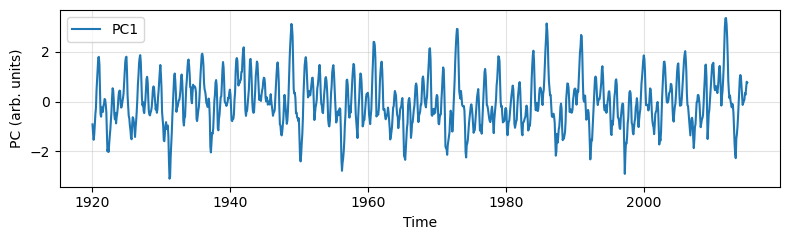

In [32]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(out["time"].values, out["PCs"].sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

In [46]:
ds_out = xr.Dataset(
    data_vars={
        "PCs":    out["PCs"],      # (time, mode)
        "Nino34": out["nino34"],   # (time)
        "anoms":   out["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": " cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014 Projected PCs and Niño 3.4",
    "climatology_ref": "ERSSTv5: 1981-01 to 2010-12",
    "notes": "EOFs computed based on ERSSTv5, weights = sqrt(cos(lat))",
})

out_path = "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc


### FCM

Classify the model data into regimes based on pseudo-PCs using the saved clustering model.

In [50]:
file = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_pcs_nino34_1920_2014.nc")
data = file["PCs"].to_numpy()
nino34 = file["Nino34"].to_numpy()

with open('../data/fcm_ersstv5.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

features = []
features.append(data)
features = np.concatenate(features, axis=1)
features = scaler.transform(features)
weights = cluster_model.predict(features)
labels = np.argmax(weights, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

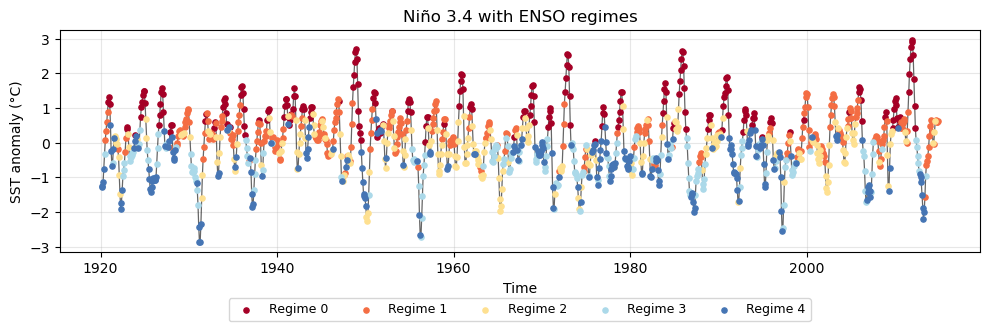

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2", "Regime 3", "Regime 4"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

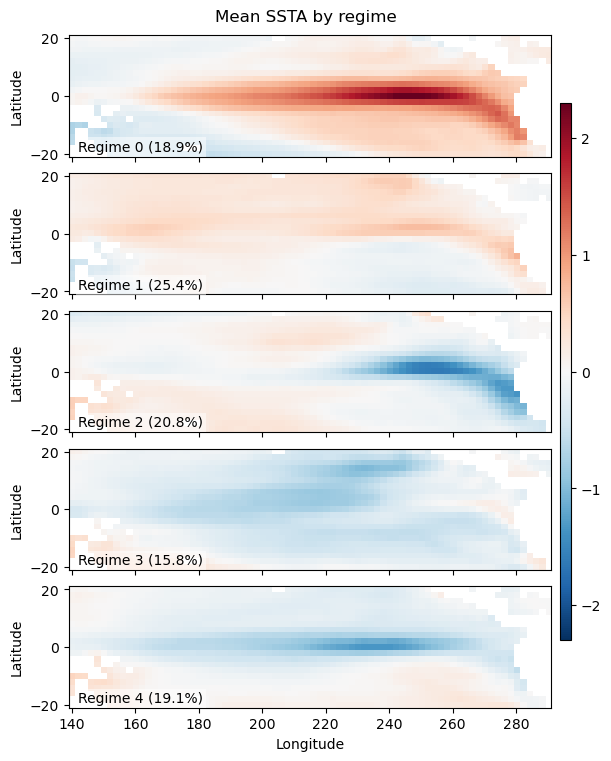

In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anoms"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png')
plt.show()

#### PCs check on obs data (projection to EOFs)

In [12]:
pcs_obs = compute_pcs(obs.sel(time=slice("1920-01", "2020-12"), lat=slice(20, -20), lon=slice(140, 290)), eof_file.sel(time=slice("1920-01", "2020-12")).EOFs, clim_ref=clim_ref_obs)  # where eofs_4 has dims (mode, lat, lon)

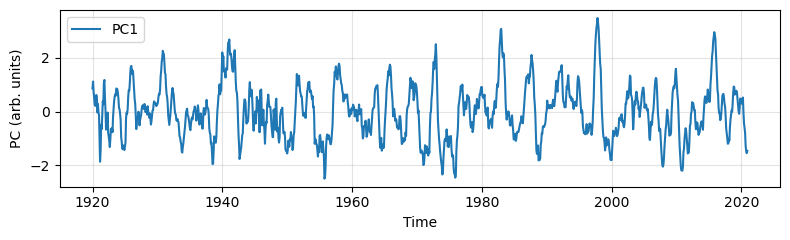

In [13]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(pcs_obs["time"].values, pcs_obs.sel(mode=1), label=f"PC1")
ax.legend()
ax.grid(True, alpha=0.35)
ax.set_xlabel("Time")
ax.set_ylabel("PC (arb. units)")
plt.tight_layout()
plt.show()
    

#### PCA check (be careful about the sign)

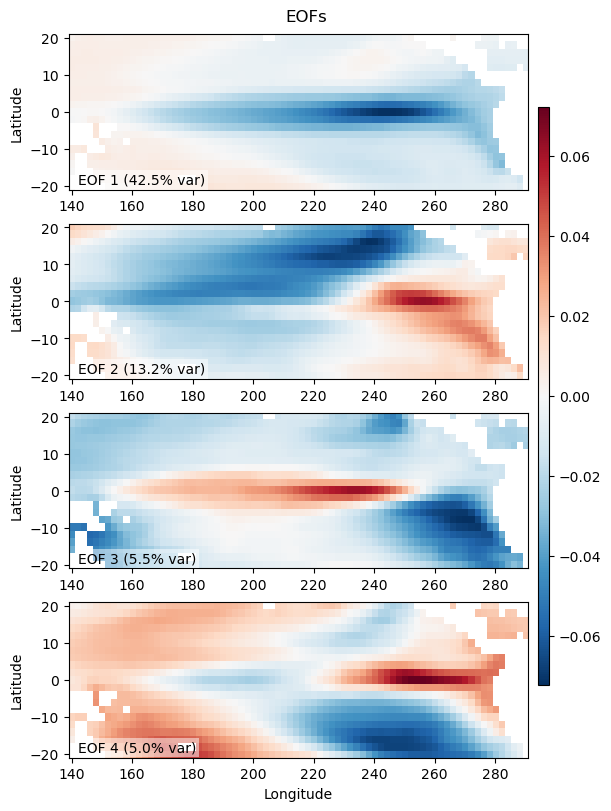

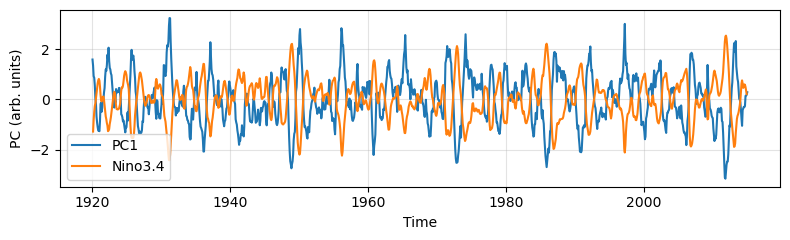

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=True,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # Auto-rename latitude/longitude if needed
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in da.dims or old in da.coords: rename_map[old] = new
    if rename_map:
        da = da.rename(rename_map)

    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    if remove_season:
        if clim_ref is None:
            clim = da.groupby("time.month").mean("time")
        elif isinstance(clim_ref, xr.DataArray):
            clim = clim_ref
        else:
            ref = da.sel(time=slice(*clim_ref)) # Select the reference period for climatology
            if ref.time.size == 0:
                raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")
            clim = ref.groupby("time.month").mean("time") # Compute monthly climatology over the reference period
        anoms = da.groupby("time.month") - clim # Subtract monthly climatology from all time steps
    else:
        anoms = da        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.sqrt(np.cos(lat_rad))
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting
    
    # anoms_w = anoms * w2d
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=w2d)
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)
    
def plot_pcs(pcs, modes=(1,2,3), nino=None):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    if nino is not None:
        ax.plot(nino["time"].values, nino, label=f"Nino3.4")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    res = pca_ersstv5(
        ds_2deg.sst.sel(time=slice("1920-01", "2014-12")),
        time_slice=("1920-01", "2014-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    # plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

In [38]:
modes_flip = [0,2,3]
for mode in modes_flip:
    res["EOFs"][mode] = -res["EOFs"][mode]
    res["PCs"][:, mode] = -res["PCs"][:, mode]

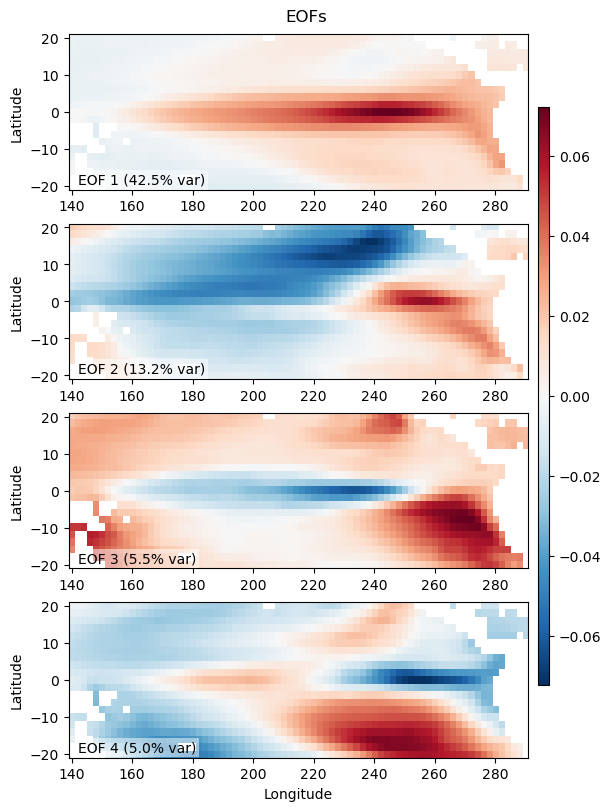

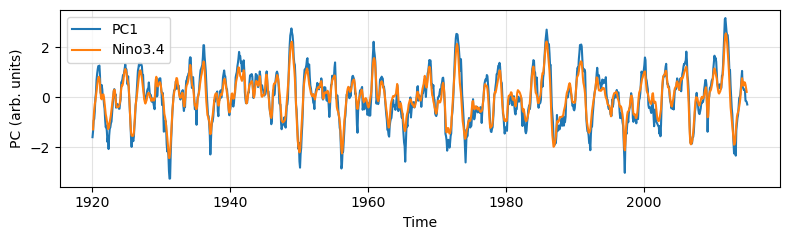

In [39]:
plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
# plt.savefig('../figure/eofs.png')
plot_pcs(res["PCs"], modes=(1,), nino=res['nino34'])

## Modeling

# Observation: 1D

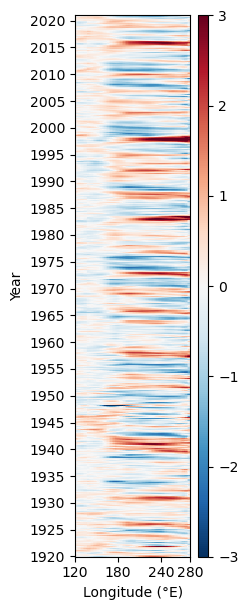

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import matplotlib.dates as mdates

ds = xr.open_dataset('../data/sst.mnmean.nc')
sst_eq = ds['sst'].sel(time=slice("1920-01", "2020-12"),
                       lon=slice(120, 280),
                       lat=slice(5, -5))

# Remove seasonal cycle (monthly climatology over a reference period)
clim_ref = ("1981-01", "2010-12")
ref = sst_eq.sel(time=slice(*clim_ref))
clim = ref.groupby("time.month").mean("time", skipna=True)
anoms = sst_eq.groupby("time.month") - clim

# Linear detrend per grid cell (along time)
def _detrend_1d(x):
    if np.all(np.isnan(x)):
        return x
    return sp_detrend(x, type="linear")

anoms = xr.apply_ufunc(
    _detrend_1d, anoms,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anoms.dtype]
)

# Area weights (cos(lat))
lat_rad = np.deg2rad(anoms["lat"])
w_lat = np.cos(lat_rad)
w2d = w_lat.broadcast_like(anoms.isel(time=0))  # (lat, lon)

# weighted mean = weighted sum / sum of weights over the same valid mask
num = (anoms * w2d).sum(dim="lat", skipna=True)
den = w2d.where(anoms.notnull()).sum(dim="lat", skipna=True)
anoms_mean = num / den  # dims: time × lon

nino34_xy = (anoms*w2d).sel(lat=slice(5, -5), lon=slice(190, 240))
nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
nino34 = nino34_mean.rolling(time=3, center=True).mean()

# Hovmöller plot
fig, ax = plt.subplots(figsize=(2.5, 6.2))  # wider than tall usually looks better
anoms_mean = anoms_mean.transpose("time", "lon") # Ensure C has shape (Ny, Nx) = (len(time), len(lon))
pcm = ax.pcolormesh(
    anoms_mean["lon"].values,                # X (Nx)
    pd.to_datetime(anoms_mean["time"].values), # Y (Ny)
    anoms_mean.values,                                # C (Ny, Nx)
    cmap="RdBu_r",
    shading="auto",
    vmin=-3, vmax=3
)
cb = plt.colorbar(pcm, ax=ax, aspect=50)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Year")
ax.yaxis.set_major_locator(mdates.YearLocator(5))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xticks([120, 180, 240, 280])
ax.set_xlim(120, 280)
plt.tight_layout()
plt.savefig('../figure/hovmoller_ersstv5.png', dpi=150)
plt.show()

In [4]:
ds_out = xr.Dataset(
    data_vars={
        "eq_ssta": anoms_mean,  # (lon, time)
        "ssta": anoms,  # (lon, time)
        "nino34": nino34,          # (time)
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 Equatorial SSTA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "SSTA are weighted by cos(lat)",
})

out_path = "../data/ssta_nino34_ersstv5_1d.nc"
ds_out.to_netcdf(out_path, format="NETCDF4")
print(f"Saved to {out_path}")

Saved to ../data/ssta_nino34_ersstv5_1d.nc


##### Check the decorrelation time

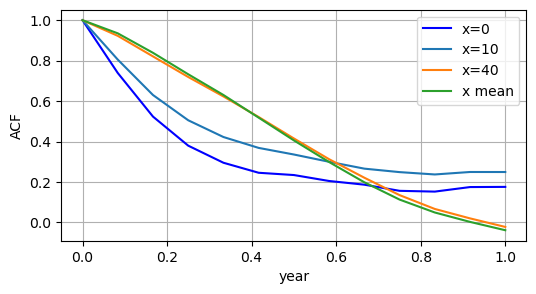

Decorrelation Time: 0.3213528926902827
Decorrelation Time: 0.41520624975343806
Decorrelation Time: 0.43892770618143573
Decorrelation Time: 0.43369687077519403


In [17]:
import numpy as np
import xarray as xr
from statsmodels.tsa.stattools import acf, ccf
from scipy.integrate import simpson
import matplotlib.pyplot as plt

file = xr.open_dataset("../data/ssta_nino34_ersstv5_1d.nc")
data = file["eq_ssta"].to_numpy()

Lag = 12
dt_ob = 1/12
acf0 = acf(data[:, 0], nlags=Lag)
acf1 = acf(data[:, 10], nlags=Lag)
acf2 = acf(data[:, 40], nlags=Lag)
acf3 = acf(np.mean(data, axis=1), nlags=Lag)
tt = np.linspace(0, Lag*dt_ob, num=Lag+1, endpoint=True)
plt.figure(figsize=(6, 3))
plt.plot(tt, acf0, color='b', label='x=0')
plt.plot(tt, acf1, label='x=10')
plt.plot(tt, acf2, label='x=40')
plt.plot(tt, acf3, label='x mean')
plt.ylabel('ACF')
plt.xlabel('year')
plt.legend()
plt.grid()
plt.show()

decorr_time = simpson(acf0, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf1, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf2, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')
decorr_time = simpson(acf3, dx=dt_ob)
print(f'Decorrelation Time: {decorr_time}')

## Clustering

### FCM

In [5]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from time import time
import pickle

def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
np.random.seed(0)

########################## load data ############################
file = xr.open_dataset("../data/ersstv5_eqSSTA_nino34_1920_2020.nc")
data = file["eq_ssta"].to_numpy()
nino34 = file["nino34"].to_numpy()
train_size = 1212 # training data size
test_size = 0 # test data size

######################### clustering ############################
K = 3 # number of clusters (regimes)
L = 0 # time delay steps
data = data[:train_size]
Nt, _ = data.shape
features = []
features.append(data)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
cluster_model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000, seed=0)
results = cluster_model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

# save the clustering model
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'scaler': scaler,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_ersstv5_1d.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

In [6]:
data_embedded.shape

(1212, 81)

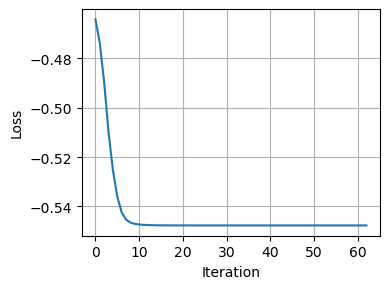

In [7]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

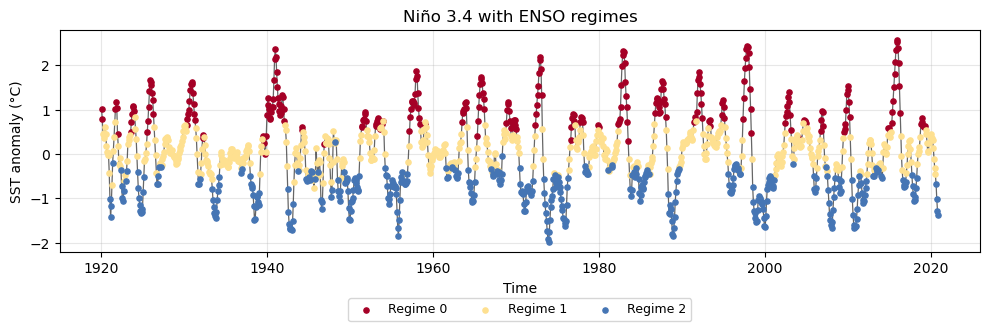

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_1d.png')
plt.show()

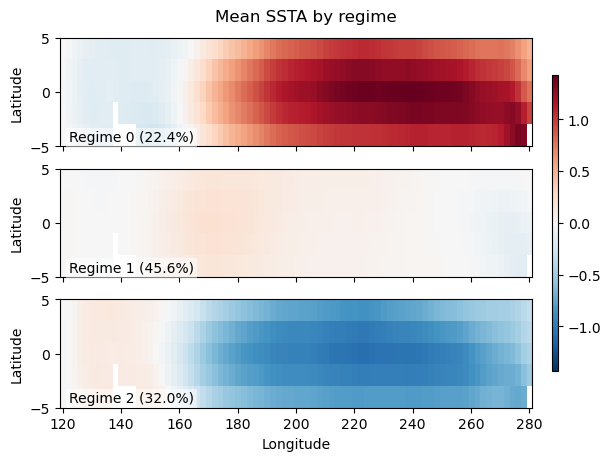

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

from plot import plot_regime_means
mean_maps, freq = mean_anom_per_regime(file["ssta"], new_labels)
plot_regime_means(mean_maps, freq, regimes=[0,1,2])
plt.savefig('../figure/meanssta_regimes_fcm_1d.png')
plt.show()

# Models: 1D

## Preprocessing

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ssh_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    dssh              (time, latitude, longitude) float32 79MB ...
    ssh_glob          (time) float32 8kB ...
    ssh_trop          (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc")
ds.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    sst               (time, latitude, longitude) float32 79MB ...
    ts_glob           (time) float32 8kB ...
    ts_trop           (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [28]:
def equatorial_mean(ds):
    import numpy as np
    import xarray as xr
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.signal import detrend as sp_detrend
    import matplotlib.dates as mdates
    
    data = ds.sel(time=slice("1920-01", "2020-12"),
                           lon=slice(120, 280),
                           lat=slice(5, -5))
    
    # # Remove seasonal cycle (monthly climatology over a reference period)
    # ds = xr.open_dataset("../data/sst.mnmean.nc")
    # clim_ref = ("1981-01", "2010-12")
    # clim = ds["sst"].sel(time=slice(*clim_ref), lat=slice(5, -5), lon=slice(120, 280)).groupby("time.month").mean("time", skipna=True)
    # anoms = sst_eq.groupby("time.month") - clim
    
    # # Linear detrend per grid cell (along time)
    # def _detrend_1d(x):
    #     if np.all(np.isnan(x)):
    #         return x
    #     return sp_detrend(x, type="linear")
    
    # anoms = xr.apply_ufunc(
    #     _detrend_1d, anoms,
    #     input_core_dims=[["time"]],
    #     output_core_dims=[["time"]],
    #     vectorize=True,
    #     dask="parallelized",
    #     output_dtypes=[anoms.dtype]
    # )
    
    # Area weights (cos(lat))
    lat_rad = np.deg2rad(data["lat"])
    w_lat = np.cos(lat_rad)
    w2d = w_lat.broadcast_like(data.isel(time=0))  # (lat, lon)
    
    # weighted mean = weighted sum / sum of weights over the same valid mask
    num = (data * w2d).sum(dim="lat", skipna=True)
    den = w2d.where(data.notnull()).sum(dim="lat", skipna=True)
    equa_mean = num / den  # dims: time × lon

    return equa_mean




In [37]:
import os
from pathlib import Path
import numpy as np
import xarray as xr


def preprocess(ds: xr.Dataset, name) -> xr.Dataset:
    """Full preprocess for a single open_dataset call."""
    # Standardize coordinates names
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in ds.dims or old in ds.coords: rename_map[old] = new
    ds = ds.rename(rename_map)

    # Ensure longitudes are 0–360
    if ds.lon.max() <= 180:
        ds = ds.assign_coords(lon=(ds.lon % 360))
    # Ensure longitudes and latitudes are ordered
    ds = ds.sortby('lon', ascending=True)
    ds = ds.sortby('lat', ascending=False)

    # Coarsening data to 2°×2° by averaging 2×2 cells (lat bins: [-20.5, -19.5] -> -20, lon bins: [139.5, 140.5] -> 140)
    ds_block = ds[name].sel(lat=slice(20.5, -20.5), lon=slice(119.5, 290.5))
    ds_2deg = ds_block.coarsen(lat=2, lon=2, boundary='trim').mean()
    lat_new = ds_block['lat'].coarsen(lat=2, boundary='trim').mean()
    lon_new = ds_block['lon'].coarsen(lon=2, boundary='trim').mean()
    ds_2deg = ds_2deg.assign_coords(lat=lat_new, lon=lon_new)
    
    return ds_2deg

# -------------------------
# Public API
# -------------------------
def process_and_merge(file_paths, out_path, var_names):
    """
    Apply the pipeline to each file and merge into one NetCDF.
    """
    # processed = []
    data_dic = {}
    for path, name in zip(file_paths, var_names):
        with xr.open_dataset(path) as ds_raw:
            ds_proc = preprocess(ds_raw, name)
            # print(ds_proc)
            ds_proc = equatorial_mean(ds_proc)
            # print(ds_proc)

        data_dic[name] = ds_proc
        # print(ds_proc)
        # processed.append(ds_proc)
    ds_out = xr.Dataset(data_dic)
    # ds_out = xr.merge(processed, join="outer")
    ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
    ds_out.attrs.update({
    "title": "Equatorial mean of model data",
    "model": "cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014",
    })
    print(f"Saved to {out_path}")
    return 

if __name__ == "__main__":
    merged = process_and_merge(file_paths= [
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_ssh_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_taux_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_tauy_1850_2014.nc",
                                    "../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_nhf_1850_2014.nc",
                                ], 
                               out_path = "../data/cmip6_ACCESS-CM2_1d.nc", 
                               var_names=["sst", "dssh", "taux", "tauy", "nhf"])

Saved to ../data/cmip6_ACCESS-CM2_1d.nc


In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")



In [39]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 1140, lon: 81)
Coordinates:
  * time     (time) datetime64[ns] 9kB 1920-01-16T12:00:00 ... 2014-12-16T12:...
  * lon      (lon) float64 648B 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
Data variables:
    sst      (time, lon) float64 739kB ...
    dssh     (time, lon) float64 739kB ...
    taux     (time, lon) float64 739kB ...
    tauy     (time, lon) float64 739kB ...
    nhf      (time, lon) float64 739kB ...

In [40]:
import numpy as np
import xarray as xr
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")

arrays = [ds[v] for v in ds.data_vars]
stacked = xr.concat(arrays, dim='var')  # shape: (var=5, time=1140, lon=81)
stacked = stacked.transpose('time', 'var', 'lon')  # shape: (1140, 5, 81)
arr = stacked.values
print(arr.shape)   # (1140, 5, 81)

(1140, 5, 81)


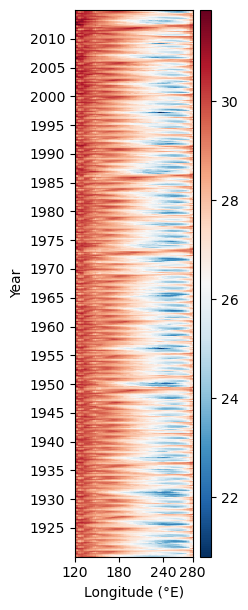

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import matplotlib.dates as mdates
# Hovmöller plot
fig, ax = plt.subplots(figsize=(2.5, 6.2))  # wider than tall usually looks better
# anoms_mean = anoms_mean.transpose("time", "lon") # Ensure C has shape (Ny, Nx) = (len(time), len(lon))
anoms_mean = ds.sst
pcm = ax.pcolormesh(
    anoms_mean["lon"].values,                # X (Nx)
    pd.to_datetime(anoms_mean["time"].values), # Y (Ny)
    anoms_mean.values,                                # C (Ny, Nx)
    cmap="RdBu_r",
    shading="auto",
)
cb = plt.colorbar(pcm, ax=ax, aspect=50)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Year")
ax.yaxis.set_major_locator(mdates.YearLocator(5))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xticks([120, 180, 240, 280])
ax.set_xlim(120, 280)
plt.tight_layout()
# plt.savefig('../figure/hovmoller_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png', dpi=150)
plt.show()

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_historical_r1i1p1f1_nhf_1850_2014.nc")

# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(119.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

def rename_lat_lon(data):
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    return data.rename(rename_map)
ds_2deg = rename_lat_lon(ds_2deg)

<bound method Mapping.keys of <xarray.Dataset> Size: 79MB
Dimensions:           (time: 1980, bound: 2, latitude: 50, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * latitude          (latitude) float64 400B -24.5 -23.5 -22.5 ... 23.5 24.5
  * longitude         (longitude) float64 2kB 100.5 101.5 102.5 ... 298.5 299.5
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB ...
    bounds_latitude   (latitude, bound) float64 800B ...
    bounds_longitude  (longitude, bound) float64 3kB ...
    nhf               (time, latitude, longitude) float32 79MB ...
    nhf_glob          (time) float32 8kB ...
    nhf_trop          (time) float32 8kB ...
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribut

In [11]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
# %matplotlib inline

%output holomap='scrubber' fps=3
ds.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

/tmp/ipykernel_4017885/816614438.py:6: HoloviewsDeprecationWarning: IPython magic is deprecated and will be removed in version 1.23.0.
  get_ipython().run_line_magic('output', "holomap='scrubber' fps=3")


:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

In [12]:
ds.sst

<xarray.DataArray 'sst' (time: 1980, latitude: 50, longitude: 200)> Size: 79MB
[19800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * latitude   (latitude) float64 400B -24.5 -23.5 -22.5 ... 22.5 23.5 24.5
  * longitude  (longitude) float64 2kB 100.5 101.5 102.5 ... 297.5 298.5 299.5
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [13]:
ds.sst.time

<xarray.DataArray 'time' (time: 1980)> Size: 16kB
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
Attributes:
    bounds:        time_bnds
    axis:          T
    realtopology:  linear

Since model data has different spatial grids from the reanalysis data, coarsening and averaging are needed to align the spatial grids.

In [23]:
# Coarsening data
# Ensure longitudes are 0–360 and sorted
if ds.longitude.max() <= 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)).sortby('longitude')
else:
    ds = ds.sortby('longitude')

# 1) Expand the subset by 0.5° so 2x2 blocks will be centered on integers
#    lat bins: [-20.5, -19.5] -> -20, [-18.5, -17.5] -> -18, ..., [19.5, 20.5] -> 20
#    lon bins: [139.5, 140.5] -> 140, ..., [289.5, 290.5] -> 290
ds_block = ds.sel(latitude=slice(-20.5, 20.5), longitude=slice(119.5, 290.5))

# 2) Coarsen to 2°×2° by averaging 2×2 cells
ds_2deg = ds_block.coarsen(latitude=2, longitude=2, boundary='trim').mean()

# 3) Set the coarsened coordinates to the mean-of-blocks (these will be integers)
lat_new = ds_block['latitude'].coarsen(latitude=2, boundary='trim').mean()
lon_new = ds_block['longitude'].coarsen(longitude=2, boundary='trim').mean()
ds_2deg = ds_2deg.assign_coords(latitude=lat_new, longitude=lon_new)

ds_2deg = ds_2deg.sortby('latitude', ascending=False)

In [24]:
def rename_lat_lon(data):
    rename_map = {}
    for old, new in [('latitude', 'lat'), ('longitude', 'lon')]:
        if old in data.dims or old in data.coords: rename_map[old] = new
    return data.rename(rename_map)
ds_2deg = rename_lat_lon(ds_2deg)

In [19]:
ds_2deg

<xarray.Dataset> Size: 13MB
Dimensions:           (time: 1980, bound: 2, lat: 21, lon: 76)
Coordinates:
  * time              (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014...
  * lat               (lat) float64 168B 20.0 18.0 16.0 ... -16.0 -18.0 -20.0
  * lon               (lon) float64 608B 140.0 142.0 144.0 ... 286.0 288.0 290.0
Dimensions without coordinates: bound
Data variables:
    time_bnds         (time, bound) datetime64[ns] 32kB 1850-01-01 ... 2015-0...
    bounds_latitude   (lat, bound) float64 336B 19.5 20.5 17.5 ... -20.5 -19.5
    bounds_longitude  (lon, bound) float64 1kB 139.5 140.5 141.5 ... 289.5 290.5
    sst               (time, lat, lon) float32 13MB 24.46 24.58 ... 25.73 nan
    ts_glob           (time) float32 8kB 13.02 13.06 14.05 ... 15.8 14.86 14.29
    ts_trop           (time) float32 8kB 25.12 25.46 25.91 ... 26.57 26.27 25.98
Attributes: (12/48)
    EnsoMetrics_disclaimer:                    The results in this file were ...
    original_attribute_activity_id:            CMIP
    original_attribute_branch_method:          standard
    original_attribute_branch_time_in_child:   0.0
    original_attribute_branch_time_in_parent:  0.0
    original_attribute_calendar:               proleptic_gregorian
    ...                                        ...
    original_attribute_table_info:             Creation Date:(30 April 2019) ...
    original_attribute_title:                  ACCESS-CM2 output prepared for...
    original_attribute_tracking_id:            hdl:21.14100/246cb7d2-3eb7-412...
    original_attribute_variable_id:            ts
    original_attribute_variant_label:          r1i1p1f1
    original_attribute_version:                v20191108

In [16]:
ds_2deg.sel(time=slice("1920-01", "2020-12")).sst.hvplot('longitude', 'latitude', cmap='RdBu_r').redim.range(sst=(-2, 30))

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sst)

## Clustering 

First compute the equatorial SSTA.

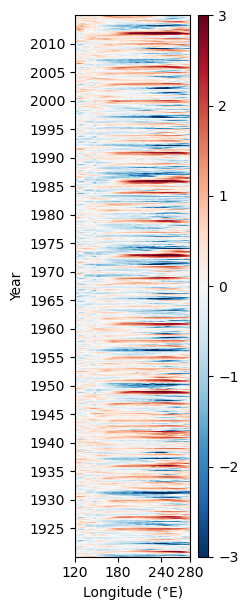

In [25]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import matplotlib.dates as mdates

sst_eq = ds_2deg.sst.sel(time=slice("1920-01", "2020-12"),
                       lon=slice(120, 280),
                       lat=slice(5, -5))

# Remove seasonal cycle (monthly climatology over a reference period)
ds = xr.open_dataset("../data/sst.mnmean.nc")
clim_ref = ("1981-01", "2010-12")
clim = ds["sst"].sel(time=slice(*clim_ref), lat=slice(5, -5), lon=slice(120, 280)).groupby("time.month").mean("time", skipna=True)
anoms = sst_eq.groupby("time.month") - clim

# Linear detrend per grid cell (along time)
def _detrend_1d(x):
    if np.all(np.isnan(x)):
        return x
    return sp_detrend(x, type="linear")

anoms = xr.apply_ufunc(
    _detrend_1d, anoms,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anoms.dtype]
)

# Area weights (cos(lat))
lat_rad = np.deg2rad(anoms["lat"])
w_lat = np.cos(lat_rad)
w2d = w_lat.broadcast_like(anoms.isel(time=0))  # (lat, lon)

# weighted mean = weighted sum / sum of weights over the same valid mask
num = (anoms * w2d).sum(dim="lat", skipna=True)
den = w2d.where(anoms.notnull()).sum(dim="lat", skipna=True)
anoms_mean = num / den  # dims: time × lon

nino34_xy = (anoms*w2d).sel(lat=slice(5, -5), lon=slice(190, 240))
nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
nino34 = nino34_mean.rolling(time=3, center=True).mean()

# Hovmöller plot
fig, ax = plt.subplots(figsize=(2.5, 6.2))  # wider than tall usually looks better
anoms_mean = anoms_mean.transpose("time", "lon") # Ensure C has shape (Ny, Nx) = (len(time), len(lon))
pcm = ax.pcolormesh(
    anoms_mean["lon"].values,                # X (Nx)
    pd.to_datetime(anoms_mean["time"].values), # Y (Ny)
    anoms_mean.values,                                # C (Ny, Nx)
    cmap="RdBu_r",
    shading="auto",
    vmin=-3, vmax=3
)
cb = plt.colorbar(pcm, ax=ax, aspect=50)
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Year")
ax.yaxis.set_major_locator(mdates.YearLocator(5))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xticks([120, 180, 240, 280])
ax.set_xlim(120, 280)
plt.tight_layout()
plt.savefig('../figure/hovmoller_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014.png', dpi=150)
plt.show()

In [26]:
ds_out = xr.Dataset(
    data_vars={
        "eq_ssta": anoms_mean,  # (lon, time)
        "ssta": anoms,  # (lon, time)
        "nino34": nino34,          # (time)
    }
)
ds_out.attrs.update({
    "title": "cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014 Equatorial SSTA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12 from ersstv5" ,
    "notes": "SSTA are weighted by cos(lat)",
})

out_path = "../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc"
ds_out.to_netcdf(out_path, format="NETCDF4", mode="w")
print(f"Saved to {out_path}")

Saved to ../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc


### FCM

Classify the model data into regimes based on pseudo-PCs using the saved clustering model.

In [6]:
import numpy as np
import xarray as xr
import pickle
from cluster import FCMEntropy, reorder_labels_by_mean_nino34

file = xr.open_dataset("../data/ssta_nino34_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.nc")
data = file["eq_ssta"].to_numpy()
nino34 = file["nino34"].to_numpy()

with open('../data/fcm_ersstv5_1d.pkl', 'rb') as f:
    fcm_model_data = pickle.load(f)
cluster_model = FCMEntropy(**fcm_model_data['config'])
cluster_model.centers = fcm_model_data['centers']
cluster_model.weights = fcm_model_data['weights']
scaler = fcm_model_data['scaler']

features = []
features.append(data)
features = np.concatenate(features, axis=1)
features = scaler.transform(features)
weights = cluster_model.predict(features)
labels = np.argmax(weights, axis=1)
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

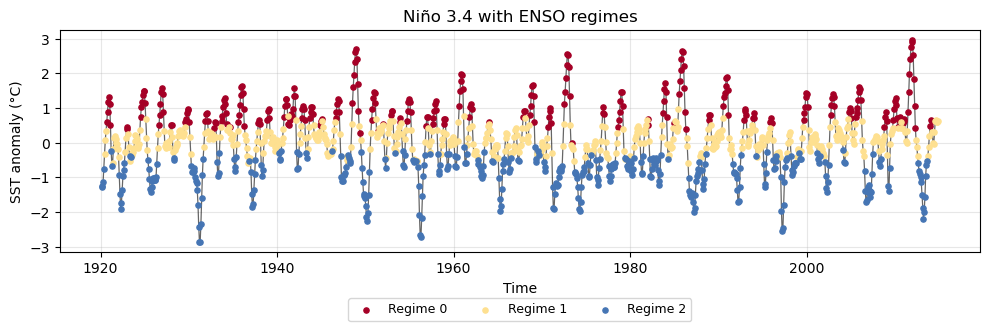

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_nino34_with_regimes

colors = [
    "#a50026",  # deep red
    # "#f46d43",  # orange-red
    "#fee090",  # light orange
    # "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 0", "Regime 1", "Regime 2"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.png')
plt.show()

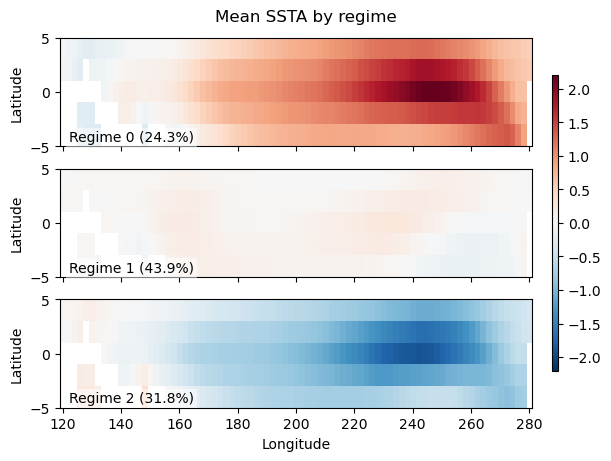

In [34]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

# from plot import plot_regime_means
mean_maps, freq = mean_anom_per_regime(file["ssta"], new_labels)
plot_regime_means(mean_maps, freq, regimes=[0,1,2])
plt.savefig('../figure/meanssta_regimes_fcm_cmip6_ACCESS-CM2_historical_r1i1p1f1_ts_1850_2014_1d.png')
plt.show()

In [7]:
data.shape

(1140, 81)

## Surrogate modeling: CNN+LSTM

In [38]:
# hybrid_cnn_lstm_forecast.py
# CNN(1D over space) + LSTM (over time) for 1-step-ahead prediction of 5-variable 1-D fields
# Input data expected shape: (T, C=5, Nx)

import os
import math
import time
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ------------------------------
# 1) Utilities
# ------------------------------

def zscore_fit(x: np.ndarray, axis=(0, 2)):
    """
    Fit mean/std per variable (channel), aggregating over time and space.
    x: (T, C, X)
    """
    mean = x.mean(axis=axis, keepdims=True)          # (1, C, 1)
    std = x.std(axis=axis, keepdims=True) + 1e-8     # (1, C, 1)
    return mean, std

def zscore_apply(x: np.ndarray, mean: np.ndarray, std: np.ndarray):
    return (x - mean) / std

def zscore_inverse(x_norm: np.ndarray, mean: np.ndarray, std: np.ndarray):
    return x_norm * std + mean

# ------------------------------
# 2) Dataset
# ------------------------------

class SpatialTimeSeriesDataset(Dataset):
    """
    Windows a (T, C, Nx) array into (seq_len -> target) samples.
    Returns:
      X_seq: (seq_len, C, Nx)
      y:     (C, Nx) at t + horizon
    """
    def __init__(self, data: np.ndarray, seq_len: int = 12, horizon: int = 1):
        assert data.ndim == 3, "data must be (T, C, Nx)"
        self.data = data.astype(np.float32)
        self.seq_len = seq_len
        self.horizon = horizon
        self.T = data.shape[0]
        self.max_start = self.T - seq_len - horizon
        if self.max_start <= 0:
            raise ValueError("Time series too short for given seq_len and horizon.")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_len]            # (L, C, Nx)
        y = self.data[idx + self.seq_len + self.horizon - 1]  # (C, Nx)
        return torch.from_numpy(x), torch.from_numpy(y)

class SeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len=1):
        self.data = data.astype(np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return data.shape[0] - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_len]
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return torch.from_numpy(x), torch.from_numpy(y.squeeze(axis=0))

# class PiecewiseSeriesDataset(Dataset):
#     def __init__(self, segments, seq_len, pred_len):
#         self.samples = []
#         for seg in segments:
#             if len(seg) < seq_len + pred_len:
#                 continue
#             for i in range(len(seg) - seq_len - pred_len + 1):
#                 x = seg[i:i + seq_len]
#                 y = seg[i + seq_len:i + seq_len + pred_len]
#                 self.samples.append((x, y))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         x, y = self.samples[idx]
#         return torch.tensor(x, dtype=torch.float32), torch.tensor(y[0], dtype=torch.float32)


# ------------------------------
# 3) Model: CNN1D (spatial) + LSTM (temporal) + decoder
# ------------------------------
class CNNEncoder1D(nn.Module):
    """
    Per-time-step spatial feature extractor over 1D transect.
    Uses AdaptiveAvgPool1d to a fixed latent length to avoid shape math headaches.
    """
    def __init__(self, in_channels, out_channels, out_dim, kernel_size=5):
        super().__init__()
        pad = kernel_size // 2
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=kernel_size, padding=pad),
            nn.GELU(),
            nn.Conv1d(64, out_channels, kernel_size=kernel_size, padding=pad),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(out_dim),  # -> (B, C_out, dim_out) # may need improvement here
        )
        self.out_channels = out_channels
        self.out_dim = out_dim

    def forward(self, x):  # x: (B, C, Nx)
        return self.net(x)  # (B, C_out, dim_out)

class CNNDecoder1D(nn.Module):
    """
    Optional spatial refinement after the linear projection.
    """
    def __init__(self, ch, kernel_size=5):
        super().__init__()
        pad =kernel_size // 2
        self.refine = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=kernel_size, padding=pad),
            nn.GELU(),
            nn.Conv1d(ch, ch, kernel_size=kernel_size, padding=pad),
        )

    def forward(self, y):  # (B, C, Nx)
        return self.refine(y)

class CNNLSTMModel(nn.Module):
    """
    CNN + LSTM model:
    - For each time step: CNN1D encodes (C, Nx) -> (latent_channels, latent_dim) -> flatten
    - LSTM over time on flattened features
    - Linear projects last LSTM output to (C_out * Nx), reshape -> (C_out, Nx)
    - Optional post-decoder 1D Conv refinement
    """
    def __init__(self, in_channels, out_channels, Nx, latent_channels=16, latent_dim=16, lstm_hidden_dim=128, lstm_layers=1, dropout=0.1, post_conv=True):
        super().__init__()
        self.Nx = Nx
        self.out_channels = out_channels

        # Spatial encoder
        self.encoder = CNNEncoder1D(in_channels=in_channels, out_channels=latent_channels, out_dim=latent_dim, kernel_size=5)
        enc_dim = latent_channels * latent_dim

        # Temporal model
        self.lstm = nn.LSTM(input_size=enc_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout if lstm_layers > 1 else 0.0)
        lstm_out_dim = lstm_hidden_dim

        # Projection to field
        self.head = nn.Sequential(
            nn.Linear(lstm_out_dim, lstm_out_dim),
            nn.GELU(),
            nn.Linear(lstm_out_dim, out_channels * Nx),
        )

        # Decoder (or simply refining)
        self.post = CNNDecoder1D(out_channels, kernel_size=5) if post_conv else None

        # Small init for stability
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):  # x: (B, L, C, Nx)
        B, L, C, Nx = x.shape  # (batch_size, seq_len, channels, grids)
        assert Nx == self.Nx, f"Expected Nx={self.Nx}, got {Nx}"

        # Encode each time step with shared CNN
        x_ = x.reshape(B * L, C, Nx)                   # (B*L, C, Nx)
        z = self.encoder(x_)                           # (B*L, latent_channels, latent_dim)
        z = z.flatten(start_dim=1)                     # (B*L, enc_dim)
        z = z.view(B, L, -1)                           # (B, L, enc_dim)

        # LSTM over time
        o, _ = self.lstm(z)                            # (B, L, lstm_out_dim)
        h_last = o[:, -1]                              # (B, lstm_out_dim)

        # Map to field
        y = self.head(h_last)                          # (B, C_out * Nx)
        y = y.view(B, self.out_channels, self.Nx)      # (B, C_out, Nx)

        if self.post is not None:
            y = self.post(y)                           # (B, C_out, Nx)
        return y


In [43]:
class ChannelZScoreScaler:
    """
    Per-channel z-score across time×space.
    """
    def __init__(self, eps: float = 1e-8):
        self.eps = eps
        self.mean = None  # (1, C, 1) float32
        self.std  = None  # (1, C, 1) float32

    def fit(self, arr: np.ndarray): # arr shape (T, C, Nx)
        mean = arr.mean(axis=(0, 2), keepdims=True)       # (1, C, 1)
        std  = arr.std(axis=(0, 2), keepdims=True) + self.eps
        self.mean = mean.astype(np.float32)
        self.std  = std.astype(np.float32)

    def transform(self, arr: np.ndarray) -> np.ndarray:
        return (arr - self.mean) / self.std

    def transform_segments(self, segments):
        out = []
        for seg in segments:
            out.append((seg - self.mean) / self.std)
        return out

    def inverse(self, arr_norm: np.ndarray) -> np.ndarray:
        return arr_norm * self.std + self.mean

    def state_dict(self):
        return {"mean": self.mean, "std": self.std, "eps": self.eps}

    def load_state_dict(self, state):
        self.mean = state["mean"]
        self.std  = state["std"]
        self.eps  = state.get("eps", 1e-8)
        
class CNNLSTMTrainer:
    def __init__(self, data, piecewise=False, data_segments=None, seed=0, device=None, seq_len=1, pred_len=1, 
                 in_channels=5, out_channels=5, latent_channels=16, latent_dim=16, lstm_hidden_dim=64, lstm_layers=1, 
                 batch_size=20, num_epochs=20, lr=1e-3, weight_decay=1e-4, grad_clip=None, 
                 train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, val_every=1, print_params=True):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.latent_channels = latent_channels
        self.latent_dim = latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_layers = lstm_layers
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.scaler = ChannelZScoreScaler()
        self._load_data(data, piecewise, data_segments, train_ratio, val_ratio, test_ratio)
        Nx = data.shape[2] if data is not None else self.train_dataset[0][0].shape[-1]
        self.model = CNNLSTMModel(in_channels, out_channels, Nx, latent_channels, latent_dim, lstm_hidden_dim, lstm_layers).to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_epochs+1)
        self.loss_fn = nn.MSELoss()
        self.grad_clip = grad_clip
        self.val_every = val_every
        if print_params:
            total = sum(p.numel() for p in self.model.parameters())
            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            enc = sum(p.numel() for p in self.model.encoder.parameters() if p.requires_grad)
            tmp = sum(p.numel() for p in self.model.lstm.parameters() if p.requires_grad)
            head = sum(p.numel() for p in self.model.head.parameters() if p.requires_grad)
            post = sum(p.numel() for p in self.model.post.parameters() if p.requires_grad)
            print(f"Encoder #parameters: {enc:,}")
            print(f"LSTM    #parameters: {tmp:,}")
            print(f"Decoder #parameters: {post+head:,}")
            print(f"TOTAL   #parameters: {total:,} (trainable {trainable:,})")


    def _load_data(self, data=None, piecewise=False, data_segments=None, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        if piecewise:
            total_size = len(data_segments)
            train_size = int(train_ratio * total_size)
            val_size = int(val_ratio * total_size)
            test_size = total_size - train_size - val_size
            print(f'train size: {train_size}, val size: {val_size}, test size: {test_size}')
            train_cat = np.concatenate(data_segments[:train_size], axis=0)  # (T_tr, C, Nx)
            self.scaler.fit(train_cat)
            train_norm = self.scaler.transform_segments(data_segments[:train_size])
            val_norm   = self.scaler.transform_segments(data_segments[train_size:train_size+val_size])
            test_norm  = self.scaler.transform_segments(data_segments[train_size+val_size:])
            self.train_dataset = PiecewiseSeriesDataset(train_norm, self.seq_len, self.pred_len)
            self.val_dataset   = PiecewiseSeriesDataset(val_norm,   self.seq_len, self.pred_len)
            self.test_dataset  = PiecewiseSeriesDataset(test_norm,  self.seq_len, self.pred_len)

        else:
            dataset = SeriesDataset(data, self.seq_len, self.pred_len) # data shape (T, C, Nx)
            total_size = len(dataset)
            train_size = int(train_ratio * total_size)
            val_size = int(val_ratio * total_size)
            test_size = total_size - train_size - val_size
            print(f'train size: {train_size}, val size: {val_size}, test size: {test_size}')
            train_raw = data[:train_size]
            self.scaler.fit(train_raw)
            data_norm = self.scaler.transform(data)
            dataset = SeriesDataset(data_norm, self.seq_len, self.pred_len) # data shape (T, C, Nx)
            self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
            self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
            self.test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, total_size))

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            pred = self.model(xb)
            loss = self.loss_fn(pred, yb)
            self.optimizer.zero_grad()
            loss.backward()
            if self.grad_clip is not None:
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
            self.optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(loader.dataset)
        return avg_loss

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        preds = []
        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            pred = self.model(xb)
            loss = self.loss_fn(pred, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(pred)
        avg_loss = total_loss / len(loader.dataset)
        pred = torch.cat(preds, dim=0)
        return avg_loss, pred

    def train(self, plot=True, save_dir_model=None, save_dir_loss=None):
        best_val = float("inf")
        start_time_total = time.time()
        train_losses = []
        val_losses = []
        for epoch in range(0, self.num_epochs + 1):
            start_time_ep = time.time()
            train_loss = self.train_one_epoch(self.train_loader)
            train_losses.append(train_loss)
            self.scheduler.step()
            if epoch % self.val_every == 0:
                val_loss, _ = self.evaluate(self.val_loader)
                val_losses.append(val_loss)
                if val_loss < best_val:
                    best_val = val_loss
                    checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'scaler_state': self.scaler.state_dict(),
                    }
                    if save_dir_model is not None:
                        torch.save(checkpoint, f"{save_dir_model}")
                    status = "✅"
                else:
                    status = ""
                time_used_ep = time.time() - start_time_ep
                print(f"Epoch {epoch}: Train {train_loss:.6f} | Val {val_loss: .6f} | Time {time_used_ep / 60:.4f} mins {status}")
            else:
                val_losses.append(np.nan)
                time_used_ep = time.time() - start_time_ep
                print(f"Epoch {epoch}: Train {train_loss:.6f} | Time {time_used_ep/60:.2f} mins")
        time_used_total = time.time() - start_time_total
        print(f"total time used: {time_used_total / 3600: .2f} hrs")
        
        if save_dir_loss is not None:
            np.savez(f"{save_dir_loss}",
            train=np.asarray(train_losses),
            val=np.asarray(val_losses),
            )
        if plot:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(4, 3))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Val Loss')
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.title("Training Loss Curve")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    def test(self, pretrain=False, pretrain_dir=None, return_physical=False):
        if pretrain:
            checkpoint = torch.load(f"{pretrain_dir}", map_location=self.device)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.scaler.load_state_dict(checkpoint["scaler_state"])
        test_loss, test_pred = self.evaluate(self.test_loader)
        print(f"Test Loss (normalized space) = {test_loss:.6f}")

        if return_physical:
            return self.scaler.inverse(test_pred.detach().cpu().numpy())
        else:
            return test_pred.to("cpu")


In [4]:
import numpy as np
import xarray as xr
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")

arrays = [ds[v] for v in ds.data_vars]
data = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values

train size: 911, val size: 113, test size: 115
Encoder #parameters: 6,800
LSTM    #parameters: 82,432
Decoder #parameters: 30,745
TOTAL   #parameters: 119,977 (trainable 119,977)
Epoch 0: Train 0.670407 | Val  0.414795 | Time 0.0061 mins ✅
Epoch 1: Train 0.305303 | Val  0.233004 | Time 0.0060 mins ✅
Epoch 2: Train 0.197115 | Val  0.179016 | Time 0.0059 mins ✅
Epoch 3: Train 0.164178 | Val  0.156600 | Time 0.0060 mins ✅
Epoch 4: Train 0.144515 | Val  0.143697 | Time 0.0058 mins ✅
Epoch 5: Train 0.132015 | Val  0.132007 | Time 0.0058 mins ✅
Epoch 6: Train 0.123459 | Val  0.132048 | Time 0.0060 mins 
Epoch 7: Train 0.117554 | Val  0.122501 | Time 0.0059 mins ✅
Epoch 8: Train 0.110166 | Val  0.116084 | Time 0.0059 mins ✅
Epoch 9: Train 0.105109 | Val  0.114753 | Time 0.0060 mins ✅
Epoch 10: Train 0.101127 | Val  0.110752 | Time 0.0058 mins ✅
Epoch 11: Train 0.098571 | Val  0.108126 | Time 0.0059 mins ✅
Epoch 12: Train 0.096247 | Val  0.107305 | Time 0.0060 mins ✅
Epoch 13: Train 0.093885 |

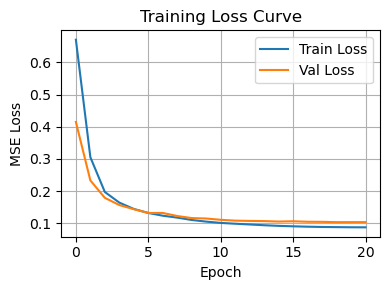

Test Loss (normalized space) = 0.116989


In [44]:
trainer = CNNLSTMTrainer(data, seq_len=1, num_epochs=20)
trainer.train(
    # save_dir_loss='../model/topobaro_lstm_train_losses.npy',
    # save_dir_model='../model/topobaro_lstm.pt'
)
test_pred = trainer.test(return_physical=True)

In [8]:
test_pred.shape

(115, 5, 81)

In [9]:
test_size = 115
data[-test_size:].shape

(115, 5, 81)

In [9]:
import numpy as np
test_size = 115
sst_pred = test_pred[:, 0]
ssh_pred = test_pred[:, 1]
taux_pred = test_pred[:, 2]
tauy_pred = test_pred[:, 3]
nhf_pred = test_pred[:, 4]

sst_truth = data[-test_size:, 0]
ssh_truth = data[-test_size:, 1]
taux_truth = data[-test_size:, 2]
tauy_truth = data[-test_size:, 3]
nhf_truth = data[-test_size:, 4]

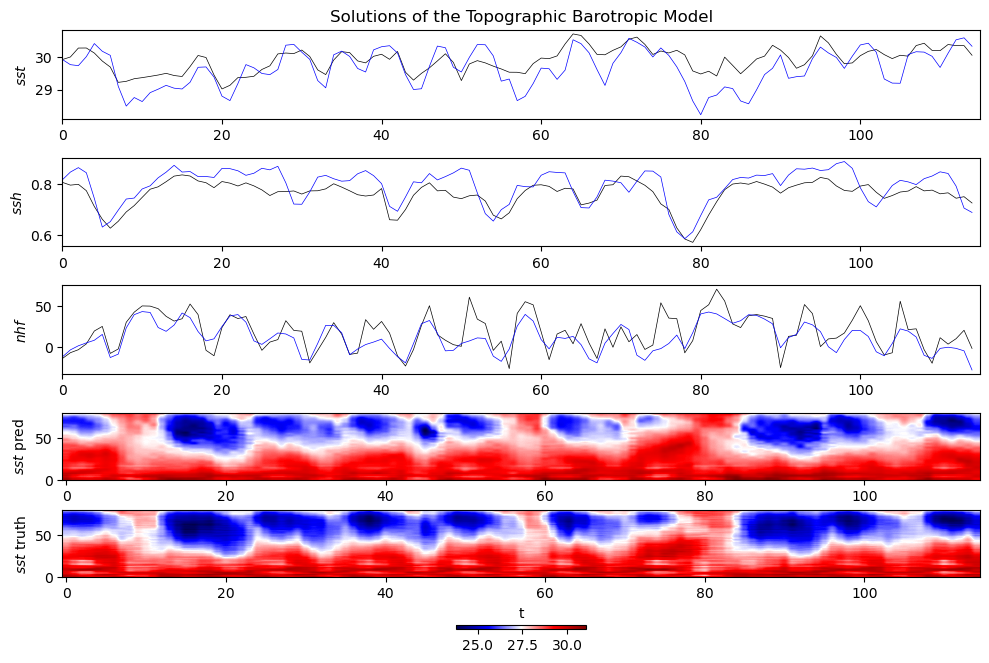

In [10]:
import matplotlib.pyplot as plt
def plot_baro_series(dt, sel0, sel1, interv, xlim,
                           data_groups, v_field, T_field, labels, colors, var_names = [r'$U$', r'$\hat{v}_1$', r'$\hat{T}_1$']):
    """
    Plot time series, PDFs (log-scale), and ACFs.
    Layout: 3 rows (variables), 3 columns (time series | PDF | ACF)
    
    Parameters:
    - *_list: list of arrays of shape (T,)
    - sel0, sel1: time index range
    - interv: interval for time series downsampling
    - xlim: x-axis limits for time plots
    - ylim: x-axis limits for PDF plots (log x-scale)
    """

    xaxis = np.arange(sel0 * dt, sel1 * dt, interv * dt)

    fig = plt.figure(figsize=(10, 7))
    widths = [1]
    heights = [1, 1, 1, 1, 1]
    spec = fig.add_gridspec(nrows=5, ncols=1, width_ratios=widths, height_ratios=heights)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    legend_lines = []
    legend_labels = []

    for row, (var_list, var_label) in enumerate(zip(data_groups, var_names)):
        ax_ts  = fig.add_subplot(spec[row, 0])  # Time series

        for i, data in enumerate(var_list):
            samples = data[sel0:sel1]
            series = data[sel0:sel1:interv]

            # --- Time Series ---
            line_model, = ax_ts.plot(xaxis, series, color=colors[i], label=labels[i], linewidth=.5)
            if row == 0 and i == 0:  # only track lines from the first row to avoid duplicates
                legend_lines.append(line_model)
                legend_labels.append(labels[i])
        
        # Axis labels/titles
        ax_ts.set_xlim(xlim)
        ax_ts.set_ylabel(var_label)
        # ax_ts.set_xlabel("t")
        if row == 0:
            ax_ts.set_title("Solutions of the Topographic Barotropic Model")


    # --- 4: v(x, t) field ---
    ax_vfield = fig.add_subplot(spec[3, 0])
    im1 = ax_vfield.imshow(
        v_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_vfield.set_ylabel(r'$sst$ pred')
    # fig.colorbar(im1, ax=ax_vfield, shrink=0.9, pad=0.1, fraction=0.005)

    # --- 5: T(x, t) field ---
    ax_Tfield = fig.add_subplot(spec[4, 0])
    im2 = ax_Tfield.imshow(
        T_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_Tfield.set_ylabel(r'$sst$ truth')
    ax_Tfield.set_xlabel("t")
    # fig.colorbar(im2, ax=ax_Tfield, shrink=0.9, pad=0.01, fraction=0.005)

    plt.tight_layout(rect=[0, 0.01, 1, 1])

    cbar = fig.colorbar(im2, ax=[ax_vfield, ax_Tfield], orientation='horizontal',
                        location='bottom', pad=0.22, fraction=0.02, aspect=30)
    # # Global legend
    # fig.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
    #            ncol=len(legend_labels), fontsize=8)
    # plt.tight_layout(rect=[0, 0, 1, 0.97])

ind_x = 10
plot_baro_series(
    dt=1,
    sel0=0,
    sel1=115,
    interv=1,
    xlim=(0, 115),
    data_groups= [[sst_truth[:, ind_x], sst_pred[:, ind_x]], [ssh_truth[:, ind_x], ssh_pred[:, ind_x]], [nhf_truth[:, ind_x], nhf_pred[:, ind_x]]],
    v_field = sst_truth,
    T_field = sst_pred,
    labels=["truth", "pred"],
    colors=["k", "b"],
    var_names=[r'$sst$', r'$ssh$', r'$nhf$']
)

Including ssh, taux, tauy, nhf as input to NNs is helpful (validated).

In [38]:

import os
import math
import time
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import math
import torch.nn.functional as F

# ------------------------------
# 1) Utilities
# ------------------------------

def zscore_fit(x: np.ndarray, axis=(0, 2)):
    """
    Fit mean/std per variable (channel), aggregating over time and space.
    x: (T, C, X)
    """
    mean = x.mean(axis=axis, keepdims=True)          # (1, C, 1)
    std = x.std(axis=axis, keepdims=True) + 1e-8     # (1, C, 1)
    return mean, std

def zscore_apply(x: np.ndarray, mean: np.ndarray, std: np.ndarray):
    return (x - mean) / std

def zscore_inverse(x_norm: np.ndarray, mean: np.ndarray, std: np.ndarray):
    return x_norm * std + mean

# ------------------------------
# 2) Dataset
# ------------------------------

class SpatialTimeSeriesDataset(Dataset):
    """
    Windows a (T, C, Nx) array into (seq_len -> target) samples.
    Returns:
      X_seq: (seq_len, C, Nx)
      y:     (C, Nx) at t + horizon
    """
    def __init__(self, data: np.ndarray, seq_len: int = 12, horizon: int = 1):
        assert data.ndim == 3, "data must be (T, C, Nx)"
        self.data = data.astype(np.float32)
        self.seq_len = seq_len
        self.horizon = horizon
        self.T = data.shape[0]
        self.max_start = self.T - seq_len - horizon
        if self.max_start <= 0:
            raise ValueError("Time series too short for given seq_len and horizon.")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_len]            # (L, C, Nx)
        y = self.data[idx + self.seq_len + self.horizon - 1]  # (C, Nx)
        return torch.from_numpy(x), torch.from_numpy(y)

class SeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len=1):
        self.data = data.astype(np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return data.shape[0] - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_len]
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return torch.from_numpy(x), torch.from_numpy(y.squeeze(axis=0))

# --------------- Small building blocks ------------------
class ConvBlock1D(nn.Module):
    """
    Conv1d -> GELU -> GroupNorm(1, C) (≈ LayerNorm per sample) with residual
    supports dilation; keeps length with padding='same'-like behavior via manual pad.
    """
    def __init__(self, ch_in, ch_out, k=5, dilation=1):
        super().__init__()
        pad = (k - 1) // 2 * dilation
        self.conv = nn.Conv1d(ch_in, ch_out, kernel_size=k, padding=pad, dilation=dilation)
        self.act = nn.GELU()
        self.norm = nn.GroupNorm(1, ch_out)
        self.skip = (ch_in == ch_out)
        if not self.skip:
            self.proj = nn.Conv1d(ch_in, ch_out, kernel_size=1)

    def forward(self, x):
        y = self.conv(x)
        y = self.act(y)
        y = self.norm(y)
        if self.skip:
            return x + y
        else:
            return self.proj(x) + y
            
class SE1D(nn.Module):
    """Squeeze-and-Excitation for 1D feature maps.
    Let the network learn which channels are important given the current feature map. 
    It computes a per-channel gate in [0,1] and rescales channels accordingly (a form of channel attention). 
    Helpful when different physics dominate at different times/locations (e.g., wind-driven vs heat-flux-driven regimes).
    """
    def __init__(self, ch, r=8):
        super().__init__()
        self.fc1 = nn.Conv1d(ch, ch // r, 1)
        self.fc2 = nn.Conv1d(ch // r, ch, 1)

    def forward(self, x):
        s = x.mean(dim=-1, keepdim=True)           # (B, C, 1)
        s = F.gelu(self.fc1(s))
        s = torch.sigmoid(self.fc2(s))
        return x * s

# # ------------------ Encoder / Decoder ------------------
# class Encoder1D(nn.Module):
#     """
#     Spatial encoder: conv stack + dilations + SE + adaptive pool to latent_dim
#     # """
#     def __init__(self, in_channels, Nx, latent_channels=32, latent_dim=32, k=5, use_se=True):
#         super().__init__()
#         self.stem = nn.Sequential(
#             nn.Conv1d(in_channels, 64, kernel_size=7, padding=3),
#             nn.GELU(),
#             nn.GroupNorm(1, 64),
#         )
#         self.block = nn.Sequential(
#             ConvBlock1D(64, 64, k, dilation=1),
#             ConvBlock1D(64, 64, k, dilation=2),
#             ConvBlock1D(64, 64, k, dilation=4),
#         )
#         self.se = SE1D(64) if use_se else nn.Identity()
#         self.proj = nn.Conv1d(64, latent_channels, kernel_size=1)
#         self.pool = nn.AdaptiveAvgPool1d(latent_dim)

#         # init
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 if m.bias is not None: nn.init.zeros_(m.bias)

#     def forward(self, x):  # (B, C, Nx)
#         y = self.stem(x)
#         y = self.block(y)
#         y = self.se(y)
#         z = self.proj(y)                 # (B, latent_ch, Nx)
#         z = self.pool(z)                 # (B, latent_ch, latent_dim)
#         return z

# class Decoder1D(nn.Module):
#     """
#     Upsamples latent along x back to Nx using light ConvTranspose1d.
#     Input:  (B, ch_in, latent_dim)
#     Output: (B, ch_out, Nx)
#     """
#     def __init__(self, ch_in, ch_hidden, ch_out, latent_dim, Nx):
#         super().__init__()
#         # choose a small number of upsampling steps
#         # we interpolate to Nx if shapes are awkward
#         self.latent_dim = latent_dim
#         self.Nx = Nx

#         self.pre = nn.Sequential(
#             ConvBlock1D(ch_in, ch_hidden, k=5, dilation=1),
#             ConvBlock1D(ch_hidden, ch_hidden, k=5, dilation=2),
#         )
#         self.up = nn.ConvTranspose1d(ch_hidden, ch_hidden, kernel_size=4, stride=2, padding=1)
#         self.tail = nn.Sequential(
#             ConvBlock1D(ch_hidden, ch_hidden, k=5, dilation=1),
#             nn.Conv1d(ch_hidden, ch_out, kernel_size=1),
#         )

#         for m in self.modules():
#             if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
#                 nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#                 if getattr(m, 'bias', None) is not None: nn.init.zeros_(m.bias)

#     def forward(self, h):  # (B, ch_in, latent_dim)
#         y = self.pre(h)                           # (B, ch_h, latent_dim)
#         # Upsample geometrically until close to Nx; then interpolate exact
#         L = y.shape[-1]
#         while L * 2 <= self.Nx:
#             y = self.up(y); L *= 2               # double length
#         if L != self.Nx:
#             y = F.interpolate(y, size=self.Nx, mode='linear', align_corners=False)
#         y = self.tail(y)
#         return y

class Encoder1D(nn.Module):
    """
    Spatial encoder: stem -> dilated conv stack -> SE -> pyramid downsampling to latent_dim.
    Channels increase gradually; final 1x1 aligns to out_channels (latent_channels).
    """
    def __init__(self, in_channels, out_channels, hidden_channels, Nx, latent_dim, k=5, use_se=True):
        super().__init__()
        self.Nx = Nx
        self.latent_dim = latent_dim
        self.out_channels = out_channels

        # progressive downsampling
        n_down = max(0, int(math.floor(math.log2(max(1, Nx // max(1, latent_dim))))))
        ch_in = in_channels
        downs = []
        for i in range(n_down):
            ch_out = min(out_channels, ch_in * 2)  # gradually increase channels
            downs += [
                ConvBlock1D(ch_in, ch_out, k, dilation=1),
                nn.Conv1d(ch_out, ch_out, kernel_size=4, stride=2, padding=1),  # length // 2
                nn.GroupNorm(1, ch_out),
                nn.GELU(),
            ]
            ch_in = ch_out
        self.down = nn.Sequential(*downs) if downs else nn.Identity()
        self.proj = nn.Conv1d(ch_in, out_channels, kernel_size=1) if ch_in != out_channels else nn.Identity()

        # Local/context block (unchanged)
        self.block = nn.Sequential(
            ConvBlock1D(out_channels, out_channels, k, dilation=1),
            ConvBlock1D(out_channels, out_channels, k, dilation=2),
            ConvBlock1D(out_channels, out_channels, k, dilation=4),
        )
        self.se = SE1D(out_channels) if use_se else nn.Identity()

        # keep a light conv after projection for a tiny bit more mixing
        self.post = ConvBlock1D(out_channels, out_channels, k=3, dilation=1)

        # init
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):  # (B, C, Nx)
        y = self.down(x)           # (B, C_h*2^k, ~Nx/2^k)
        y = self.proj(y)           # (B, C_latent, ~)
        y = self.block(y)          # (B, C_h, Nx)
        y = self.se(y)             # (B, C_h, Nx)
        y = self.post(y)           # (B, C_latent, ~)

        # exact align to latent_dim with a single, final interpolate if needed
        if y.shape[-1] != self.latent_dim:
            y = F.interpolate(y, size=self.latent_dim, mode='linear', align_corners=False)
        return y                    # (B, latent_ch, latent_dim)


class Decoder1D(nn.Module):
    """
    Mirrors Encoder1D: progressive upsampling back to Nx (stride-2 ConvTranspose1d),
    then a single interpolate to hit Nx exactly if necessary.
    Input:  (B, latent_channels, latent_dim)
    Output: (B, out_channels, Nx)
    """
    def __init__(self, in_channels, out_channels, hidden_channels, Nx, latent_dim, k=5, use_se=True):
        super().__init__()
        self.latent_dim = latent_dim
        self.Nx = Nx

        # pre-processor
        self.pre = ConvBlock1D(in_channels, in_channels, k=3, dilation=1)

        self.se = SE1D(in_channels) if use_se else nn.Identity()
        
        # Local/context block (unchanged)
        self.block = nn.Sequential(
            ConvBlock1D(in_channels, in_channels, k, dilation=1),
            ConvBlock1D(in_channels, in_channels, k, dilation=2),
            ConvBlock1D(in_channels, in_channels, k, dilation=4),
        )
        
        # progressive upsampling
        n_up = max(0, int(math.floor(math.log2(max(1, Nx // max(1, latent_dim))))))
        ups = []
        ch_in = in_channels
        for i in range(n_up):
            ch_out = max(out_channels, ch_in // 2)  # keep width stable or gently reduce
            ups += [
                nn.ConvTranspose1d(ch_in, ch_in, kernel_size=4, stride=2, padding=1),  # length * 2
                nn.GroupNorm(1, ch_in),
                nn.GELU(),
                ConvBlock1D(ch_in, ch_out, k=5, dilation=1),
            ]
            ch_in = ch_out
        self.up = nn.Sequential(*ups) if ups else nn.Identity()
        self.proj = nn.Conv1d(ch_out, out_channels, kernel_size=1) if ch_out != out_channels else nn.Identity()

        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
                nn.init.xavier_uniform_(m.weight)
                if getattr(m, 'bias', None) is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, h):  # (B, latent_channels, latent_dim)
        y = self.pre(h)                # (B, C_latent, latent_dim)
        y = self.se(y)             # (B, C_hidden, Nx)
        y = self.block(y)          # (B, C_hidden, Nx)
        y = self.up(y)                 # (B, C_latent/2^k, ~latent_dim * 2^k)
        y = self.proj(y)               # (B, C_hidden, ~latent_dim * 2^k)
        if y.shape[-1] != self.Nx:
            y = F.interpolate(y, size=self.Nx, mode='linear', align_corners=False) # (B, C_hidden, Nx)
        return y

# ------------------ Temporal core (shared across latent positions) ------------------
class PositionWiseLSTM(nn.Module):
    """
    Run the same LSTM across time for each latent position independently.
    Input:  z_t per time step encoded to (B, L, C_lat, D_lat)
    We reshape to (B*D_lat, L, C_lat) -> LSTM -> take last hidden -> (B, H, D_lat)
    """
    def __init__(self, in_channels, hidden_channels=128, layers=1, dropout=0.1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_channels,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        H = hidden_channels * (2 if bidirectional else 1)
        self.proj = nn.Linear(H, in_channels)

    def forward(self, z):  # (B, L, C, D)
        B, L, C, D = z.shape
        z_ = z.permute(0, 3, 1, 2).contiguous()          # (B, D, L, C)
        z_ = z_.view(B * D, L, C)                        # (B*D, L, C)
        o, _ = self.lstm(z_)                             # (B*D, L, H)
        h_last = o[:, -1, :]                             # (B*D, H)
        h_last = self.proj(h_last)                       # (B*D, C)
        h = h_last.view(B, D, -1).permute(0, 2, 1)       # (B, C, D)
        return h
        
# ------------------ Full model ------------------
class CNNPosLSTM1D(nn.Module):
    """
    Spatial encoder -> position-wise temporal LSTM -> upsampling decoder.
    Keeps spatial locality and avoids giant linear projection to (C_out * Nx).
    """
    def __init__(
        self,
        in_channels,          # e.g., 5 (SST, SSH, tau_x, tau_y, Q_net)
        out_channels,         # predict same 5 or subset
        latent_channels,
        hidden_channels,
        Nx,                   # original transect length
        latent_dim=16,
        lstm_hidden_dim=128,
        lstm_layers=1,
        bidirectional=False,
        dropout=0.1,
        use_se=True,
    ):
        super().__init__()
        self.Nx = Nx
        self.out_channels = out_channels
        self.encoder = Encoder1D(in_channels, latent_channels, hidden_channels, Nx, latent_dim, k=5, use_se=use_se)
        self.temporal = PositionWiseLSTM(latent_channels, lstm_hidden_dim, lstm_layers, dropout, bidirectional)
        self.decoder = Decoder1D(latent_channels, out_channels, hidden_channels, Nx, latent_dim, k=5, use_se=use_se)

    def forward(self, x):  # x: (B, L, C, Nx)
        B, L, C, Nx = x.shape
        assert Nx == self.Nx, f"Expected Nx={self.Nx}, got {Nx}"

        # Encode each time step (shared weights)
        x_ = x.reshape(B * L, C, Nx)
        z = self.encoder(x_)                              # (B*L, C_lat, D_lat)
        C_lat, D_lat = z.shape[1], z.shape[2]
        z = z.view(B, L, C_lat, D_lat)                    # (B, L, C_lat, D_lat)

        # Temporal per latent position
        h = self.temporal(z)                              # (B, H, D_lat)

        # Decode to field
        y = self.decoder(h)                               # (B, out_C, Nx)
        return y

class ChannelZScoreScaler:
    """
    Per-channel z-score across time×space.
    """
    def __init__(self, eps: float = 1e-8):
        self.eps = eps
        self.mean = None  # (1, C, 1) float32
        self.std  = None  # (1, C, 1) float32

    def fit(self, arr: np.ndarray): # arr shape (T, C, Nx)
        mean = arr.mean(axis=(0, 2), keepdims=True)       # (1, C, 1)
        std  = arr.std(axis=(0, 2), keepdims=True) + self.eps
        self.mean = mean.astype(np.float32)
        self.std  = std.astype(np.float32)

    def transform(self, arr: np.ndarray) -> np.ndarray:
        return (arr - self.mean) / self.std

    def transform_segments(self, segments):
        out = []
        for seg in segments:
            out.append((seg - self.mean) / self.std)
        return out

    def inverse(self, arr_norm: np.ndarray) -> np.ndarray:
        return arr_norm * self.std + self.mean

    def state_dict(self):
        return {"mean": self.mean, "std": self.std, "eps": self.eps}

    def load_state_dict(self, state):
        self.mean = state["mean"]
        self.std  = state["std"]
        self.eps  = state.get("eps", 1e-8)
        
class CNNLSTMTrainer:
    def __init__(self, data, piecewise=False, data_segments=None, seed=0, device=None, seq_len=1, pred_len=1, 
                 in_channels=5, out_channels=5, latent_channels=16, hidden_channels=5, latent_dim=16, lstm_hidden_dim=64, lstm_layers=1, 
                 batch_size=20, num_epochs=20, lr=1e-3, weight_decay=1e-4, grad_clip=None, 
                 train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, val_every=1, print_params=True,
                ):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.seq_len, self.pred_len = seq_len, pred_len
        self.latent_channels, self.latent_dim = latent_channels, latent_dim
        self.lstm_hidden_dim, self.lstm_layers = lstm_hidden_dim, lstm_layers
        self.batch_size, self.num_epochs = batch_size, num_epochs
        self.grad_clip, self.val_every = grad_clip, val_every
        self.scaler = ChannelZScoreScaler()
        self._load_data(data, piecewise, data_segments, train_ratio, val_ratio, test_ratio)
        Nx = data.shape[2] if data is not None else self.train_dataset[0][0].shape[-1]
        # self.model = CNNPosLSTM1D(in_channels, out_channels, Nx, latent_channels, latent_dim, lstm_hidden_dim, lstm_layers, dec_hidden=dec_hidden).to(self.device)
        self.model = CNNPosLSTM1D(in_channels=in_channels, out_channels=out_channels, latent_channels=latent_channels, 
                                  hidden_channels=hidden_channels, Nx=Nx, latent_dim=latent_dim,
                                  lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_epochs+1)
        self.loss_fn = nn.MSELoss()
        if print_params:
            total = sum(p.numel() for p in self.model.parameters())
            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            enc = sum(p.numel() for p in self.model.encoder.parameters() if p.requires_grad)
            tmp = sum(p.numel() for p in self.model.temporal.parameters() if p.requires_grad)
            dec = sum(p.numel() for p in self.model.decoder.parameters() if p.requires_grad)
            print(f"Encoder #parameters: {enc:,}")
            print(f"LSTM    #parameters: {tmp:,}")
            print(f"Decoder #parameters: {dec:,}")
            print(f"TOTAL   #parameters: {total:,} (trainable {trainable:,})")

    def _load_data(self, data=None, piecewise=False, data_segments=None, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        if piecewise:
            total_size = len(data_segments)
            train_size = int(train_ratio * total_size)
            val_size = int(val_ratio * total_size)
            test_size = total_size - train_size - val_size
            print(f'train size: {train_size}, val size: {val_size}, test size: {test_size}')
            train_cat = np.concatenate(data_segments[:train_size], axis=0)  # (T_tr, C, Nx)
            self.scaler.fit(train_cat)
            train_norm = self.scaler.transform_segments(data_segments[:train_size])
            val_norm   = self.scaler.transform_segments(data_segments[train_size:train_size+val_size])
            test_norm  = self.scaler.transform_segments(data_segments[train_size+val_size:])
            self.train_dataset = PiecewiseSeriesDataset(train_norm, self.seq_len, self.pred_len)
            self.val_dataset   = PiecewiseSeriesDataset(val_norm,   self.seq_len, self.pred_len)
            self.test_dataset  = PiecewiseSeriesDataset(test_norm,  self.seq_len, self.pred_len)

        else:
            dataset = SeriesDataset(data, self.seq_len, self.pred_len) # data shape (T, C, Nx)
            total_size = len(dataset)
            train_size = int(train_ratio * total_size)
            val_size = int(val_ratio * total_size)
            test_size = total_size - train_size - val_size
            print(f'train size: {train_size}, val size: {val_size}, test size: {test_size}')
            train_raw = data[:train_size]
            self.scaler.fit(train_raw)
            data_norm = self.scaler.transform(data)
            dataset = SeriesDataset(data_norm, self.seq_len, self.pred_len) # data shape (T, C, Nx)
            self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
            self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
            self.test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, total_size))

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            pred = self.model(xb)
            loss = self.loss_fn(pred, yb)
            self.optimizer.zero_grad()
            loss.backward()
            if self.grad_clip is not None:
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
            self.optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(loader.dataset)
        return avg_loss

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        preds = []
        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            pred = self.model(xb)
            loss = self.loss_fn(pred, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(pred)
        avg_loss = total_loss / len(loader.dataset)
        pred = torch.cat(preds, dim=0)
        return avg_loss, pred

    def train(self, plot=True, save_dir_model=None, save_dir_loss=None):
        best_val = float("inf")
        start_time_total = time.time()
        train_losses = []
        val_losses = []
        for epoch in range(0, self.num_epochs + 1):
            start_time_ep = time.time()
            train_loss = self.train_one_epoch(self.train_loader)
            train_losses.append(train_loss)
            self.scheduler.step()
            if epoch % self.val_every == 0:
                val_loss, _ = self.evaluate(self.val_loader)
                val_losses.append(val_loss)
                if val_loss < best_val:
                    best_val = val_loss
                    checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'scaler_state': self.scaler.state_dict(),
                    }
                    if save_dir_model is not None:
                        torch.save(checkpoint, f"{save_dir_model}")
                    status = "✅"
                else:
                    status = ""
                time_used_ep = time.time() - start_time_ep
                print(f"Epoch {epoch}: Train {train_loss:.6f} | Val {val_loss: .6f} | Time {time_used_ep / 60:.4f} mins {status}")
            else:
                val_losses.append(np.nan)
                time_used_ep = time.time() - start_time_ep
                print(f"Epoch {epoch}: Train {train_loss:.6f} | Time {time_used_ep/60:.2f} mins")
        time_used_total = time.time() - start_time_total
        print(f"total time used: {time_used_total / 3600: .2f} hrs")
        
        if save_dir_loss is not None:
            np.savez(f"{save_dir_loss}",
            train=np.asarray(train_losses),
            val=np.asarray(val_losses),
            )
        if plot:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(4, 3))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Val Loss')
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.title("Training Loss Curve")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    def test(self, pretrain=False, pretrain_dir=None, return_physical=False):
        if pretrain:
            checkpoint = torch.load(f"{pretrain_dir}", map_location=self.device)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.scaler.load_state_dict(checkpoint["scaler_state"])
        test_loss, test_pred = self.evaluate(self.test_loader)
        print(f"Test Loss (normalized space) = {test_loss:.6f}")

        if return_physical:
            return self.scaler.inverse(test_pred.detach().cpu().numpy())
        else:
            return test_pred.to("cpu")


In [11]:
import numpy as np
import xarray as xr
ds = xr.open_dataset("../data/cmip6_ACCESS-CM2_1d.nc")

arrays = [ds[v] for v in ds.data_vars]
data = xr.concat(arrays, dim='var').transpose('time', 'var', 'lon').values

train size: 911, val size: 113, test size: 115
Encoder #parameters: 66,584
LSTM    #parameters: 20,992
Decoder #parameters: 27,141
TOTAL   #parameters: 114,717 (trainable 114,717)
Epoch 0: Train 0.782837 | Val  0.248533 | Time 0.0125 mins ✅
Epoch 1: Train 0.211576 | Val  0.176948 | Time 0.0124 mins ✅
Epoch 2: Train 0.162814 | Val  0.145655 | Time 0.0123 mins ✅
Epoch 3: Train 0.138705 | Val  0.131089 | Time 0.0124 mins ✅
Epoch 4: Train 0.123447 | Val  0.118914 | Time 0.0124 mins ✅
Epoch 5: Train 0.115103 | Val  0.111754 | Time 0.0124 mins ✅
Epoch 6: Train 0.109277 | Val  0.111026 | Time 0.0124 mins ✅
Epoch 7: Train 0.103970 | Val  0.102030 | Time 0.0125 mins ✅
Epoch 8: Train 0.100816 | Val  0.104046 | Time 0.0124 mins 
Epoch 9: Train 0.096998 | Val  0.098295 | Time 0.0124 mins ✅
Epoch 10: Train 0.094828 | Val  0.097775 | Time 0.0124 mins ✅
Epoch 11: Train 0.091851 | Val  0.092334 | Time 0.0124 mins ✅
Epoch 12: Train 0.089537 | Val  0.098499 | Time 0.0124 mins 
Epoch 13: Train 0.087805 |

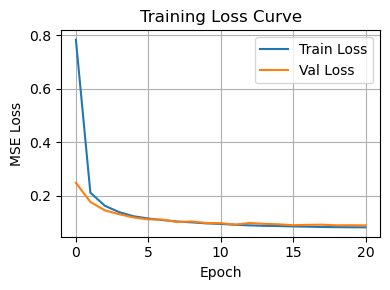

Test Loss (normalized space) = 0.105596


In [59]:
trainer = CNNLSTMTrainer(data, seq_len=1, in_channels=5, out_channels=5, 
                         latent_channels=16, latent_dim=16, lstm_hidden_dim=64, lstm_layers=1, dec_hidden=32,
                         batch_size=20, num_epochs=20, lr=1e-3,)
trainer.train(
    # save_dir_loss='../model/topobaro_lstm_train_losses.npy',
    # save_dir_model='../model/topobaro_lstm.pt'
)
test_pred = trainer.test(return_physical=True)

train size: 911, val size: 113, test size: 115
Encoder #parameters: 34,275
LSTM    #parameters: 29,736
Decoder #parameters: 44,080
TOTAL   #parameters: 108,091 (trainable 108,091)
Epoch 0: Train 0.647735 | Val  0.311741 | Time 0.0184 mins ✅
Epoch 1: Train 0.233708 | Val  0.189535 | Time 0.0187 mins ✅
Epoch 2: Train 0.166938 | Val  0.151589 | Time 0.0187 mins ✅
Epoch 3: Train 0.139014 | Val  0.137593 | Time 0.0187 mins ✅
Epoch 4: Train 0.122722 | Val  0.128561 | Time 0.0187 mins ✅
Epoch 5: Train 0.112402 | Val  0.115142 | Time 0.0188 mins ✅
Epoch 6: Train 0.108084 | Val  0.116029 | Time 0.0187 mins 
Epoch 7: Train 0.101129 | Val  0.112007 | Time 0.0187 mins ✅
Epoch 8: Train 0.096760 | Val  0.104370 | Time 0.0187 mins ✅
Epoch 9: Train 0.092960 | Val  0.098573 | Time 0.0187 mins ✅
Epoch 10: Train 0.093310 | Val  0.109697 | Time 0.0187 mins 
Epoch 11: Train 0.089805 | Val  0.095704 | Time 0.0187 mins ✅
Epoch 12: Train 0.084929 | Val  0.096777 | Time 0.0187 mins 
Epoch 13: Train 0.084796 | 

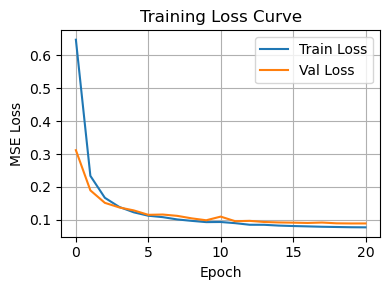

Test Loss (normalized space) = 0.102454


In [41]:
trainer = CNNLSTMTrainer(data, seq_len=1, in_channels=5, out_channels=5, 
                         latent_channels=40, hidden_channels=32, latent_dim=16, 
                         lstm_hidden_dim=64, lstm_layers=1,
                         batch_size=20, num_epochs=20, lr=1e-3)
trainer.train(
    # save_dir_loss='../model/topobaro_lstm_train_losses.npy',
    # save_dir_model='../model/topobaro_lstm.pt'
)
test_pred = trainer.test(return_physical=True)

In [52]:
import numpy as np
test_size = 115
sst_pred = test_pred[:, 0]
ssh_pred = test_pred[:, 1]
taux_pred = test_pred[:, 2]
tauy_pred = test_pred[:, 3]
nhf_pred = test_pred[:, 4]

sst_truth = data[-test_size:, 0]
ssh_truth = data[-test_size:, 1]
taux_truth = data[-test_size:, 2]
tauy_truth = data[-test_size:, 3]
nhf_truth = data[-test_size:, 4]

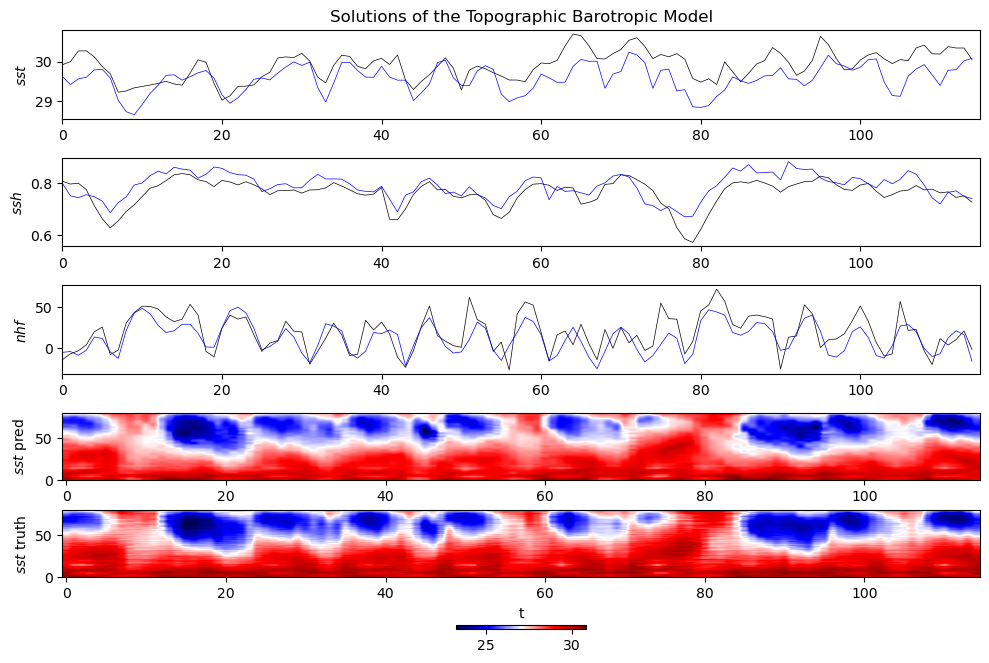

In [37]:
import matplotlib.pyplot as plt
def plot_baro_series(dt, sel0, sel1, interv, xlim,
                           data_groups, v_field, T_field, labels, colors, var_names = [r'$U$', r'$\hat{v}_1$', r'$\hat{T}_1$']):
    """
    Plot time series, PDFs (log-scale), and ACFs.
    Layout: 3 rows (variables), 3 columns (time series | PDF | ACF)
    
    Parameters:
    - *_list: list of arrays of shape (T,)
    - sel0, sel1: time index range
    - interv: interval for time series downsampling
    - xlim: x-axis limits for time plots
    - ylim: x-axis limits for PDF plots (log x-scale)
    """

    xaxis = np.arange(sel0 * dt, sel1 * dt, interv * dt)

    fig = plt.figure(figsize=(10, 7))
    widths = [1]
    heights = [1, 1, 1, 1, 1]
    spec = fig.add_gridspec(nrows=5, ncols=1, width_ratios=widths, height_ratios=heights)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    legend_lines = []
    legend_labels = []

    for row, (var_list, var_label) in enumerate(zip(data_groups, var_names)):
        ax_ts  = fig.add_subplot(spec[row, 0])  # Time series

        for i, data in enumerate(var_list):
            samples = data[sel0:sel1]
            series = data[sel0:sel1:interv]

            # --- Time Series ---
            line_model, = ax_ts.plot(xaxis, series, color=colors[i], label=labels[i], linewidth=.5)
            if row == 0 and i == 0:  # only track lines from the first row to avoid duplicates
                legend_lines.append(line_model)
                legend_labels.append(labels[i])
        
        # Axis labels/titles
        ax_ts.set_xlim(xlim)
        ax_ts.set_ylabel(var_label)
        # ax_ts.set_xlabel("t")
        if row == 0:
            ax_ts.set_title("Solutions of the Topographic Barotropic Model")


    # --- 4: v(x, t) field ---
    ax_vfield = fig.add_subplot(spec[3, 0])
    im1 = ax_vfield.imshow(
        v_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_vfield.set_ylabel(r'$sst$ pred')
    # fig.colorbar(im1, ax=ax_vfield, shrink=0.9, pad=0.1, fraction=0.005)

    # --- 5: T(x, t) field ---
    ax_Tfield = fig.add_subplot(spec[4, 0])
    im2 = ax_Tfield.imshow(
        T_field[sel0:sel1, :].T,
        origin='lower',
        aspect='auto',
        # extent=[sel0 * dt, sel1 * dt, 0, np.pi*2],
        # vmin=-10, vmax=10, 
        cmap='seismic'
    )
    ax_Tfield.set_ylabel(r'$sst$ truth')
    ax_Tfield.set_xlabel("t")
    # fig.colorbar(im2, ax=ax_Tfield, shrink=0.9, pad=0.01, fraction=0.005)

    plt.tight_layout(rect=[0, 0.01, 1, 1])

    cbar = fig.colorbar(im2, ax=[ax_vfield, ax_Tfield], orientation='horizontal',
                        location='bottom', pad=0.22, fraction=0.02, aspect=30)
    # # Global legend
    # fig.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
    #            ncol=len(legend_labels), fontsize=8)
    # plt.tight_layout(rect=[0, 0, 1, 0.97])

ind_x = 10
plot_baro_series(
    dt=1,
    sel0=0,
    sel1=115,
    interv=1,
    xlim=(0, 115),
    data_groups= [[sst_truth[:, ind_x], sst_pred[:, ind_x]], [ssh_truth[:, ind_x], ssh_pred[:, ind_x]], [nhf_truth[:, ind_x], nhf_pred[:, ind_x]]],
    v_field = sst_truth,
    T_field = sst_pred,
    labels=["truth", "pred"],
    colors=["k", "b"],
    var_names=[r'$sst$', r'$ssh$', r'$nhf$']
)